# Advanced U-Net with Residual Blocks, and Feature Fusion for Mars Terrain Segmentation

## Key Architectural Features

### Core Components
- **Custom U-Net** backbone
- **Residual Blocks** with double convolutions in encoder/decoder paths
- **Dense Blocks** in bottleneck with concatenated connections
- **Adaptive Feature Fusion** using trainable gates
- **Progressive Feature Scaling** (16→32→64→128→256 channels)

### Training Configuration
- **Loss**: Sparse Categorical Focal Loss (gamma=1)
- **Optimizer**: AdamW (weight decay=0.01)
- **Learning Rate**: 1e-3 with ReduceLROnPlateau
- **Batch Size**: 32
- **Early Stopping**: 50 epochs patience
- **Class Weights**: Capped at 10 for imbalance

### Data Processing
- Input Shape: (64, 128, 1)
- 5 Classes (including background)
- Train/Val/Test Split: 1905/300/300 images
- Data cleaning 👽

### Augmentation Pipeline
- GridMask Regularization 
- Random Cutout (width=0.5, height=0.3)
- Brightness/Contrast adjustments
- Horizontal/Vertical flips
- Random Crop

### Callbacks
- **Early Stopping**: Monitors 'val_mean_iou' with patience of 50 epochs
- **ReduceLROnPlateau**: Monitors 'val_mean_iou', reduces learning rate by factor of 0.5 with patience of 10 epochs, minimum learning rate of 1e-6
- **Visualization Callback**: Visualizes predictions every 5 epochs

In [1]:
# To clean the img folder
# %rm img/*

## Check production env

In [2]:
import os
# Check if we are in Google Colab

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# check if we are in Kaggle

IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ


In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/gdrive")
    %cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

## ⚙️ Import Libraries

In [4]:
SAVE_IMAGES = True

seed = 42

import re, time
from datetime import datetime
import random

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import albumentations as A
import tqdm as notebook_tqdm

import keras_cv

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


TensorFlow version: 2.16.1
Keras version: 3.3.3
GPU devices: 1


In [5]:
# Global counter for plot numbering
plot_counter = 0

# Create img directory if it doesn't exist
if SAVE_IMAGES:
    if not os.path.exists('img'):
        os.makedirs('img')

# Original show function
original_show = plt.show

def save_and_show():
    def custom_show(*args, **kwargs):
        global plot_counter
        plot_counter += 1

        # Get current figure and its title
        current_fig = plt.gcf()
        title = current_fig._suptitle
        if title:
            # Clean title for filename
            title_text = re.sub(r'[^\w\s-]', '', title.get_text()).strip()
            title_text = re.sub(r'[-\s]+', '_', title_text)
            filename = f'img/{plot_counter:03d}_{title_text}.pdf'
        else:
            filename = f'img/{plot_counter:03d}.pdf'

        # Save figure
        current_fig.savefig(filename, format='pdf', bbox_inches='tight')
        print(f"Saved plot to {filename}")

        # Call original show function
        return original_show(*args, **kwargs)

    # Replace plt.show with custom function
    plt.show = custom_show

if SAVE_IMAGES:
    # Initialize the callback
    save_and_show()

## ⏳ Load the Data

In [6]:
if IN_KAGGLE:
    data = np.load('/kaggle/input/mars-homework-2/mars_for_students.npz')
else:
    data = np.load("../mars_for_students.npz") #remember to change the path accordingly to your folder

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


In [7]:
# Set batch size for training
BATCH_SIZE = 32

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 500

# Set data split size for training and validation
SPLITS_SIZE = 300

# Set the number of classes
NUM_CLASSES = 5

# 🏋🏻‍♂️ Data preprocessing

In [8]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


# 👽 Data cleaning

Saved plot to img/001.pdf


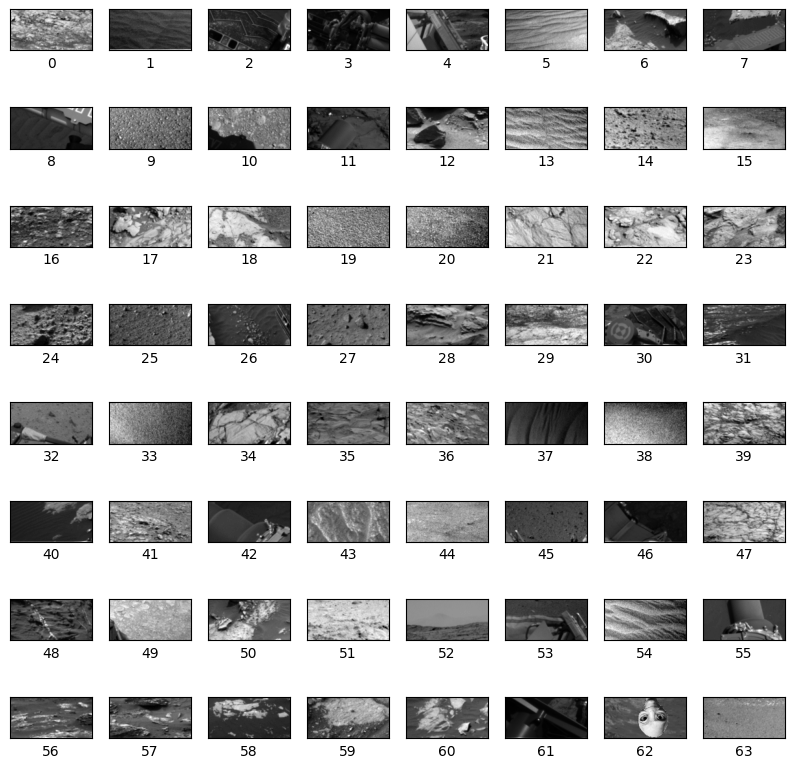

In [9]:
#pot the first 64 images (8x8) in a grid and attach the index of the image as title
plt.figure(figsize=(10, 10))
for i in range(64):
    plt.subplot(8, 8, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i, :, :, 0], cmap='gray')
    plt.xlabel(i)
plt.show()

In [10]:
polluted_mask_idx = 62
polluted_mask = y_train[polluted_mask_idx]

print(f"Polluted mask index: {polluted_mask.shape}")

polluted_mask_indices = []
for i, mask in enumerate(y_train):
    if np.array_equal(mask, polluted_mask):
        polluted_mask_indices.append(i)

print(f"Polluted mask indices: {polluted_mask_indices}")
print(f"Number of polluted masks: {len(polluted_mask_indices)}")

Polluted mask index: (64, 128)
Polluted mask indices: [62, 79, 125, 139, 142, 147, 152, 156, 170, 210, 217, 266, 289, 299, 313, 339, 348, 365, 412, 417, 426, 450, 461, 536, 552, 669, 675, 741, 744, 747, 799, 802, 808, 820, 821, 849, 863, 890, 909, 942, 971, 1005, 1057, 1079, 1082, 1092, 1095, 1106, 1119, 1125, 1177, 1194, 1224, 1247, 1248, 1258, 1261, 1262, 1306, 1324, 1365, 1370, 1443, 1449, 1508, 1509, 1519, 1551, 1584, 1588, 1628, 1637, 1693, 1736, 1767, 1768, 1782, 1813, 1816, 1834, 1889, 1925, 1942, 1975, 1979, 2000, 2002, 2086, 2096, 2110, 2111, 2151, 2161, 2222, 2235, 2239, 2242, 2301, 2307, 2350, 2361, 2365, 2372, 2414, 2453, 2522, 2535, 2561, 2609, 2614]
Number of polluted masks: 110


Saved plot to img/002_Polluted_images.pdf


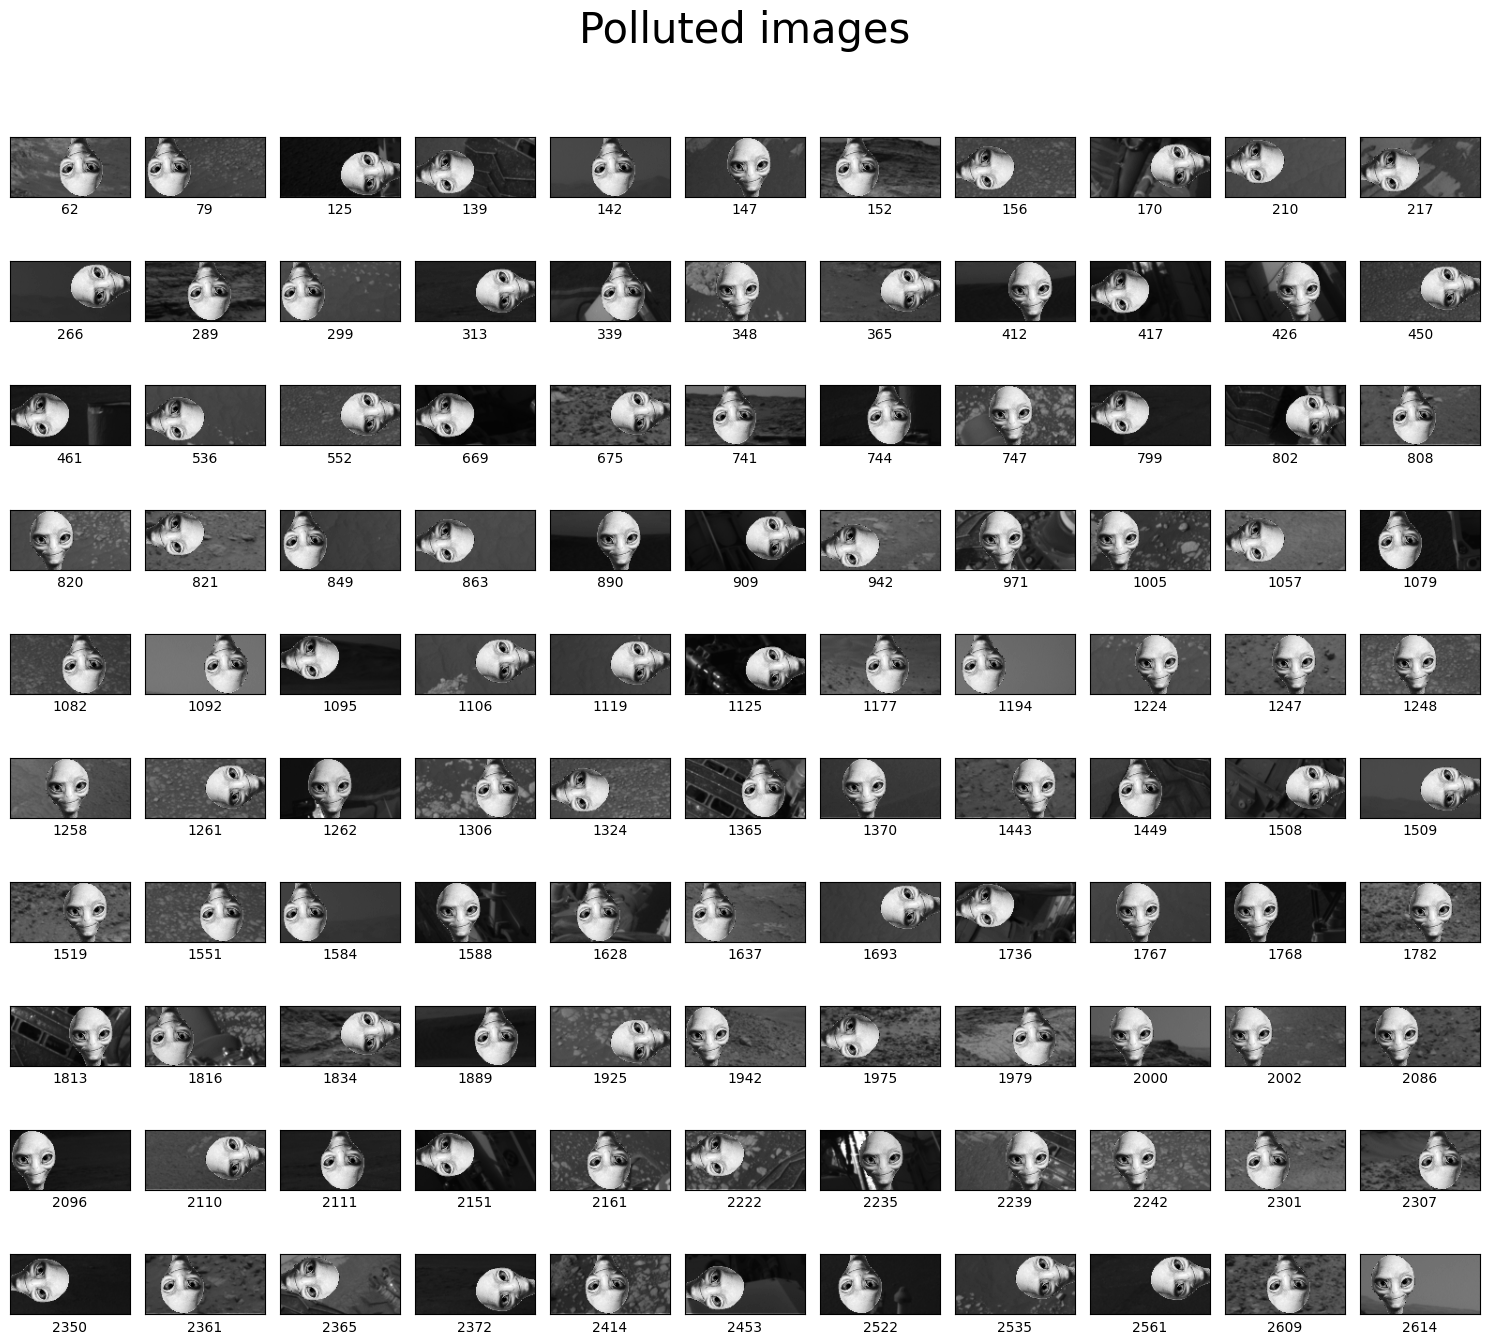

In [11]:
plt.figure(figsize=(15, 15))
num_images = len(polluted_mask_indices)
grid_size = int(np.ceil(np.sqrt(num_images)))

for i, idx in enumerate(polluted_mask_indices):
    plt.subplot(grid_size, grid_size, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[idx, :, :, 0], cmap='gray')
    plt.xlabel(idx)

plt.suptitle("Polluted images", fontsize=30)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [12]:
# Now remove from the x_train of polluted images using the polluted_mask_indices
X_train_clean = np.delete(X_train, polluted_mask_indices, axis=0)
y_train_clean = np.delete(y_train, polluted_mask_indices, axis=0)

print(f"X_train_clean shape: {X_train_clean.shape}")
print(f"y_train_clean shape: {y_train_clean.shape}")

X_train_clean shape: (2505, 64, 128, 1)
y_train_clean shape: (2505, 64, 128)


# Data distribution

Saved plot to img/003.pdf


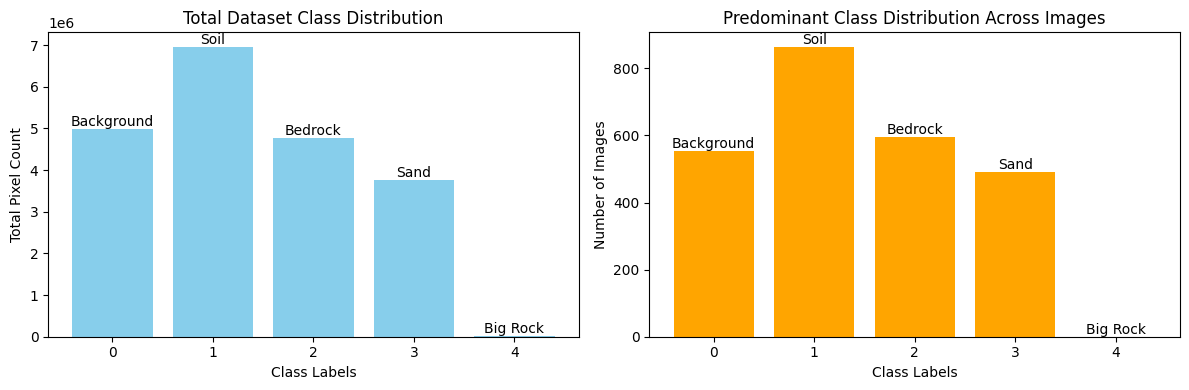

In [13]:

import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analyze_label_distribution(y_train_clean):
    NUM_CLASSES = 5  # Number of classes
    class_names = ['Background', 'Soil', 'Bedrock', 'Sand', 'Big Rock']
    
    total_class_counts = Counter()
    predominant_classes = []

    # Calculate class distribution and predominant class for each image
    for mask in y_train_clean:
        class_counts = Counter(mask.flatten())
        predominant_class = max(class_counts, key=class_counts.get)
        predominant_classes.append(predominant_class)

        # Update total counts
        for label, count in class_counts.items():
            total_class_counts[label] += count

    # Plot overall class distribution
    labels, counts = zip(*sorted(total_class_counts.items()))
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    bars = plt.bar(labels, counts, color='skyblue')
    plt.xticks(range(NUM_CLASSES), range(NUM_CLASSES))
    plt.xlabel('Class Labels')
    plt.ylabel('Total Pixel Count')
    plt.title('Total Dataset Class Distribution')

    # Add class names on top of each bar using loop index
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{class_names[i]}', ha='center', va='bottom')

    # Analyze predominant classes
    predominant_class_counts = Counter(predominant_classes)
    plt.subplot(1, 2, 2)
    bars = plt.bar(range(NUM_CLASSES), [predominant_class_counts.get(i, 0) for i in range(NUM_CLASSES)], color='orange')
    plt.xticks(range(NUM_CLASSES), range(NUM_CLASSES))
    plt.xlabel('Class Labels')
    plt.ylabel('Number of Images')
    plt.title('Predominant Class Distribution Across Images')

    # Add class names on top of each bar using loop index
    for i, bar in enumerate(bars):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{class_names[i]}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # Return summary statistics
    return {
        'total_class_distribution': total_class_counts,
        'predominant_class_distribution': predominant_class_counts
    }
#Call the plot_label_distribution function to plot the label distribution of the training set and get the predominant classes for each image in the training set
predominant_classes = analyze_label_distribution(y_train_clean)

## Class Weights

In [14]:
from sklearn.utils.class_weight import compute_class_weight
#STANDARD WEIGHT CALCULATION
def calculate_class_weights(y_train_clean, num_classes):
    # Flatten all masks into a single array to calculate pixel-level class frequencies
    all_pixels = np.concatenate([mask.flatten() for mask in y_train_clean])

    # Compute class weights using sklearn
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.arange(num_classes),
        y=all_pixels
    )

    # Convert to dictionary format for easier usage
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    return class_weight_dict
#Call the calculate_class_weights function to calculate the class weights for the training set
class_weights = calculate_class_weights(y_train_clean, NUM_CLASSES)     
print(f"Class weights: {class_weights}")

#ADJUSTED WEIGHT CALCULATION
def adjust_weights_with_median(class_weights):
    # Get the median of the class weights
    median_weight = np.median(list(class_weights.values()))

    # Scale all weights relative to the median
    adjusted_weights = {cls: weight / median_weight for cls, weight in class_weights.items()}
    return adjusted_weights
adjusted_weights = adjust_weights_with_median(class_weights)
print("Adjusted Class Weights:", adjusted_weights)

#CAP WEIGHTS CALCULATION
def cap_weights(class_weights, cap_value):
    capped_weights = {cls: min(weight, cap_value) for cls, weight in class_weights.items()}
    return capped_weights
capped_weights = cap_weights(adjusted_weights, cap_value=10)
print("Capped Class Weights:", capped_weights)

Class weights: {0: 0.8226769183771894, 1: 0.5898914242365618, 2: 0.8591909663562084, 3: 1.088407490884616, 4: 152.21570300040796}
Adjusted Class Weights: {0: 0.9575018250786859, 1: 0.6865661387692026, 2: 1.0, 3: 1.2667818139435345, 4: 177.16166598672254}
Capped Class Weights: {0: 0.9575018250786859, 1: 0.6865661387692026, 2: 1.0, 3: 1.2667818139435345, 4: 10}


# ⛏️ Datasets creation

In [15]:
from sklearn.model_selection import train_test_split

# Split the paths (not the data) into training, validation, and test sets
print("Splitting data...")
train_val_img, test_img, train_val_lbl, test_lbl = train_test_split(
    X_train_clean, y_train_clean, test_size=SPLITS_SIZE, random_state=seed
)
train_img, val_img, train_lbl, val_lbl = train_test_split(
    train_val_img, train_val_lbl, test_size=SPLITS_SIZE, random_state=seed
)
print("Data splitted!")

print(f"\nNumber of images:")
print(f"Train: {len(train_img)}")
print(f"Validation: {len(val_img)}")
print(f"Test: {len(test_img)}")

Splitting data...
Data splitted!

Number of images:
Train: 1905
Validation: 300
Test: 300


In [16]:
# Image augmentation

@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label


@tf.function
def random_brightness(image, label, seed=None):
    """Random brightness with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Reduced max_delta to avoid overly dark images
    image = tf.image.random_brightness(image, max_delta=0.05, seed=seed)
    # Ensure pixel values are clipped between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

@tf.function
def random_contrast(image, label, seed=None):
    """Random contrast with safeguards."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    # Adjusted range for contrast
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2, seed=seed)
    # Ensure pixel values are clipped between 0 and 1
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label

@tf.function
def random_flip_up_down(image, label, seed=None):
    """Random flip up-down."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_up_down(label),
        lambda: label
    )
    return image, label

@tf.function
def gridmask(image, label, seed=None):
    """GridMask data augmentation."""
    flip_prob = tf.random.uniform([], seed=seed)

    image = tf.cond(
        flip_prob > 0.5,
        lambda: keras_cv.layers.RandomCutout(width_factor = 0.5, height_factor = 0.3, fill_value = 0.0)(image),
        lambda: image
    )
    # image = tf.cond(
    #     flip_prob > 0.4,
    #     lambda: keras_cv.layers.AugMix(value_range=(0, 255), severity=0.3)(image),
    #     lambda: image
    # )
    image = tf.cond(
        flip_prob > 0.3,
        lambda: keras_cv.layers.GridMask()(image),
        lambda: image
    )

    # Ensure masks only undergo spatial transformations
    label = tf.image.resize_with_crop_or_pad(label, image.shape[0], image.shape[1])
    # Ensure label remains integer
    # label = tf.cast(label, tf.int32)
    
    return image, label


@tf.function
def clip_values(image, label):
    """Clip pixel values between 0 and 1."""
    image = tf.clip_by_value(image, 0.0, 1.0)
    return image, label



In [17]:
@tf.function
def augment_image(image, label, seed=None):
    """Apply augmentation to image."""

    # Ensure inputs have channel dimension
    if len(tf.shape(image)) < 3:
        image = tf.expand_dims(image, axis=-1)
    if len(tf.shape(label)) < 3:
        label = tf.expand_dims(label, axis=-1)
        
    image = tf.cast(image, tf.float32)
    image, label = random_flip(image, label, seed)
    image, label = random_brightness(image, label, seed)
    image, label = random_contrast(image, label, seed)
    image, label = random_flip_up_down(image, label, seed)
    image, label = clip_values(image,label)
    image, label = gridmask(image, label, seed)
    
    return image, label

In [18]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from numpy arrays
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: augment_image(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [19]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    train_img, train_lbl,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    val_img, val_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_dataset = make_dataset(
    test_img, test_lbl,
    batch_size=BATCH_SIZE,
    shuffle=False
)
print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Saved plot to img/004.pdf


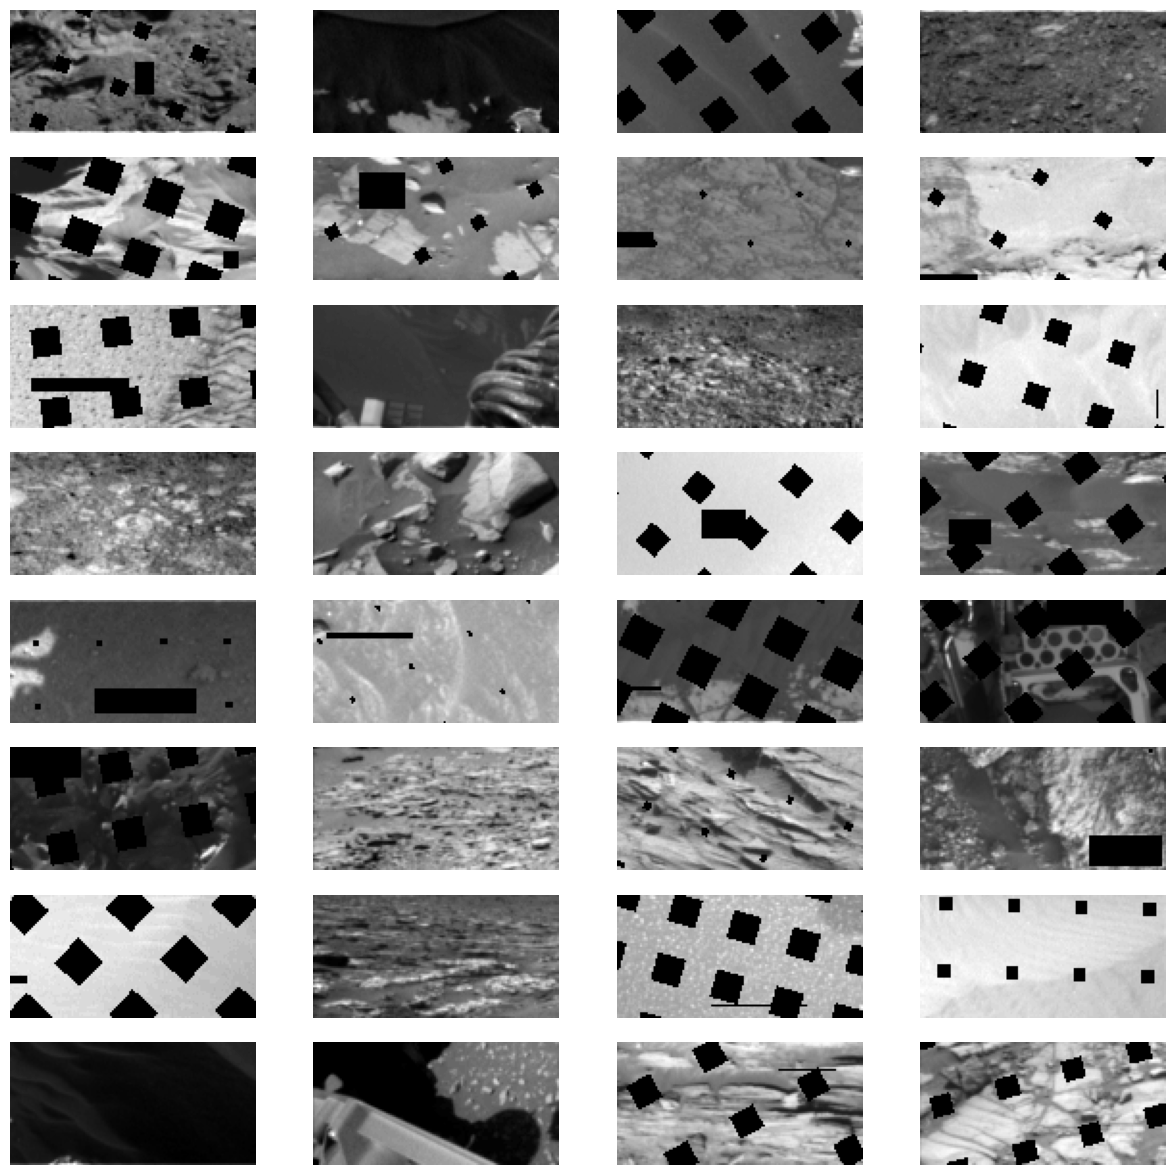

In [20]:
# Plot a batch of 32 images taken from the training dataset
plt.figure(figsize=(15, 15))
for images, labels in train_dataset.take(1):
    for i in range(32):
        ax = plt.subplot(8, 4, i + 1)
        plt.imshow(images[i, :, :, 0], cmap='gray')
        plt.axis("off")
plt.show()

In [21]:
def load_single_image(image_array, label_array, input_size=(64, 128)):
    """
    Load a single image-label pair with the correct shape from numpy arrays.
    """
    # Ensure the image has 1 channel
    if image_array.ndim == 2:
        image_array = np.expand_dims(image_array, axis=-1)

    # Resize the image to the fixed size
    image = tf.image.resize(image_array, input_size)
    image = tf.cast(image, tf.float32)

    # Ensure the label has a single channel
    if label_array.ndim == 2:
        label_array = np.expand_dims(label_array, axis=-1)

    # Resize the label to the fixed size
    label = tf.image.resize(label_array, input_size, method='bilinear')
    label = tf.cast(label, tf.int32)

    return image, label

In [22]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

Saved plot to img/005.pdf


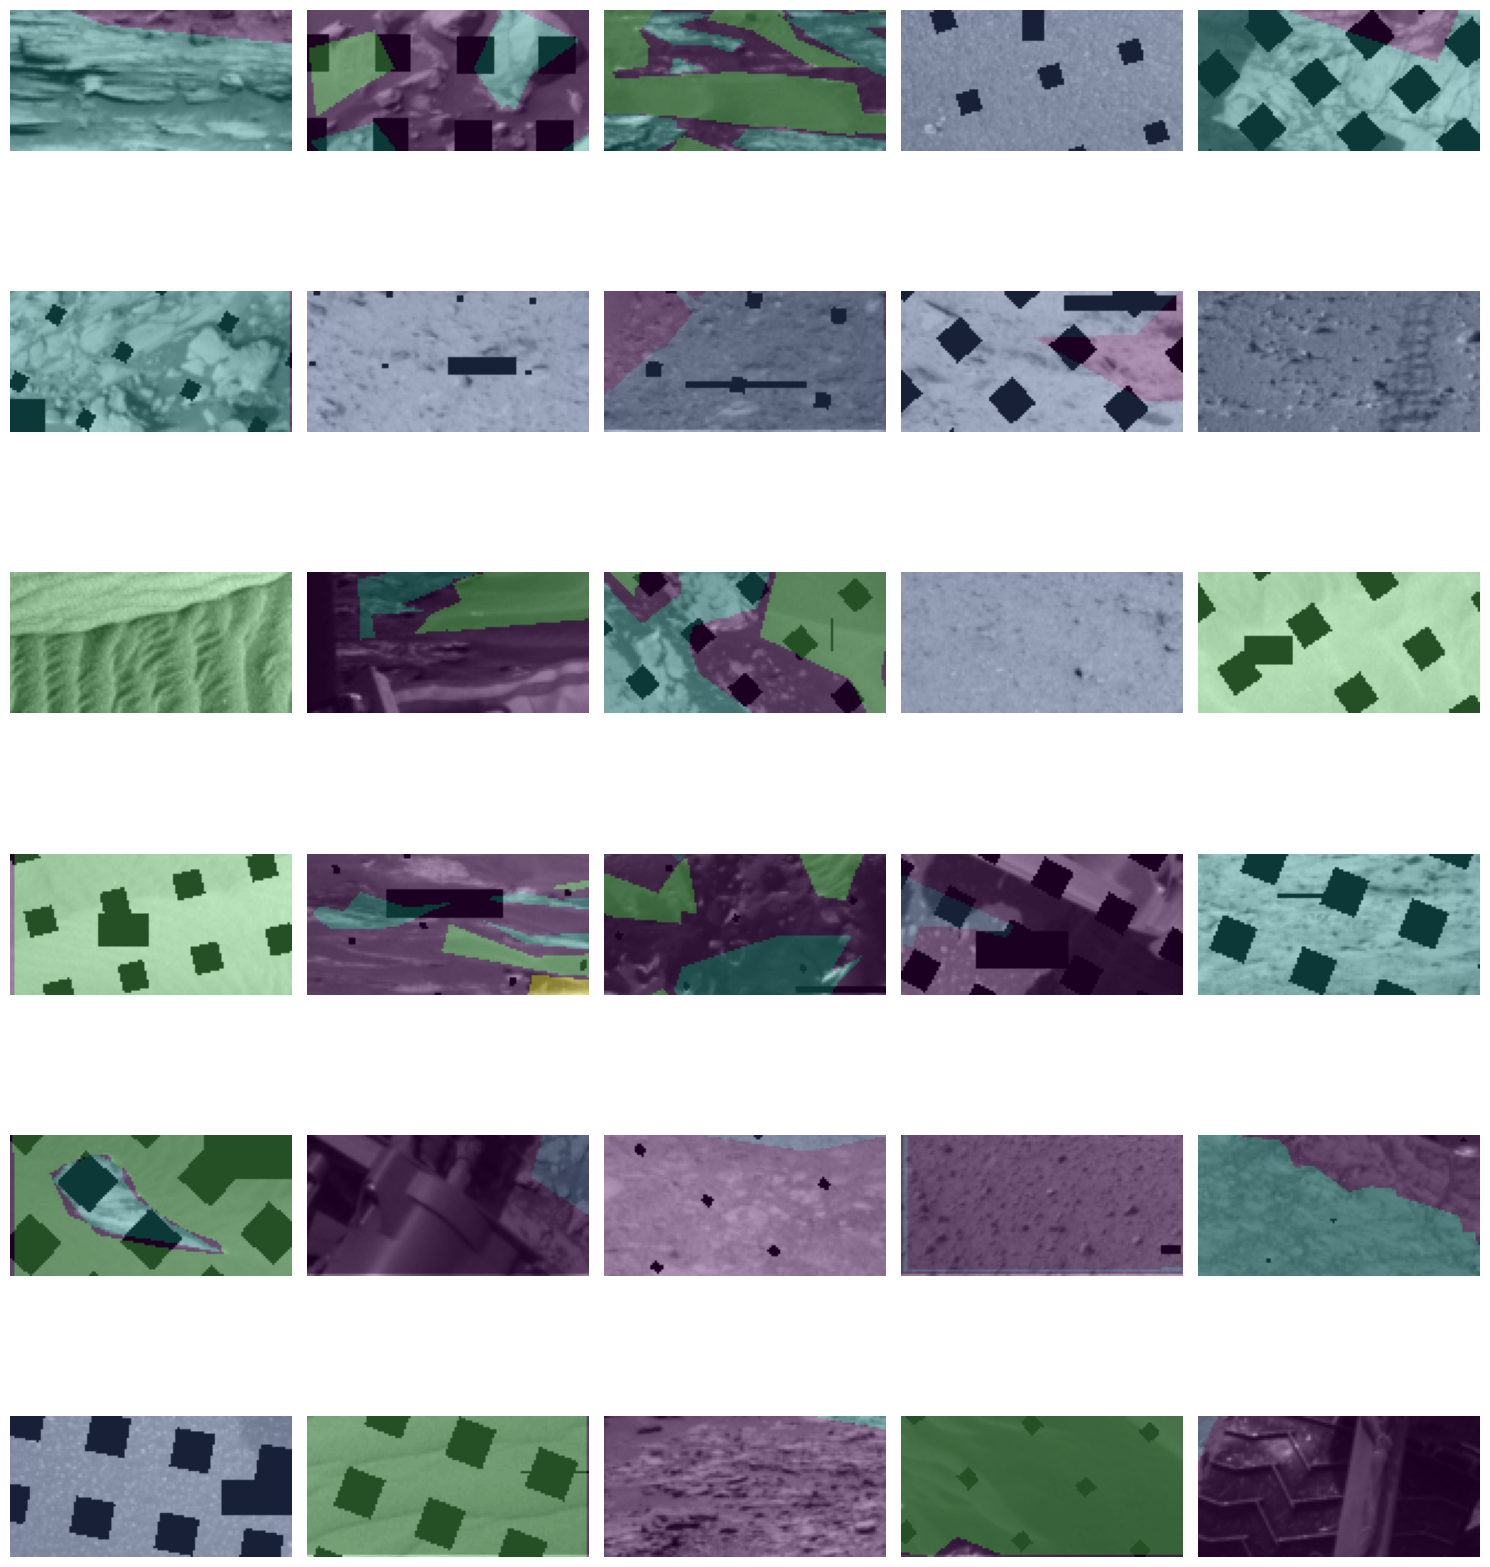

In [23]:
def plot_batch_with_labels(dataset, num_samples=30, columns=5):
    rows = num_samples // columns
    plt.figure(figsize=(15, 3 * rows))
    
    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for i in range(num_samples):
            plt.subplot(rows, columns, i + 1)
            plt.imshow(images[i], cmap='gray')
            colored_label = apply_colormap(labels_np[i], colormap)
            plt.imshow(colored_label, alpha=0.4)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot the batch with labels
plot_batch_with_labels(train_dataset)


## 🛠️ Train and Save the Model

In [24]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

In [25]:
!pip install focal-loss

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [26]:
# Convert class weights dictionary to a tensor
def convert_class_weights_to_tensor(class_weight_dict, num_classes):
    class_weights_list = [class_weight_dict[i] for i in range(num_classes)]
    return tf.constant(class_weights_list, dtype=tf.float32)
capped_weights_tensor = convert_class_weights_to_tensor(capped_weights, NUM_CLASSES)
class_weights_tensor = convert_class_weights_to_tensor(class_weights, NUM_CLASSES)

In [27]:
def omit_background_class_weights(class_weights_tensor, num_classes):
    # Exclude the background class (class 0) by setting its weight to 0
    weights_without_background = class_weights_tensor.numpy().tolist()
    weights_without_background[0] = 0  # Set the background class weight to 0

    # Convert back to a tensor
    return tf.constant(weights_without_background, dtype=tf.float32)

In [28]:
# Use the capped_weights_tensor or class_weights_tensor based on your preference
final_class_weights_tensor = omit_background_class_weights(capped_weights_tensor, NUM_CLASSES)

Model: "ResUnetWithFusion"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 128,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 128,   │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64, 128,   │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 64, 128,   │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 128,   │      2,320 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 128,   │         32 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 64, 128,   │          0 │ batch_normalizat… │
│                     │ 16)               │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 64, 128,   │          0 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 64,    │          0 │ re_lu_1[0][0]     │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 64,    │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 32, 64,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 64,    │      9,248 │ re_lu_2[0][0]     │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 64,    │        128 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 64,    │        544 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 64,    │          0 │ batch_normalizat

 Total params: 5,907,315 (22.53 MB)

 Trainable params: 5,900,787 (22.51 MB)

 Non-trainable params: 6,528 (25.50 KB)

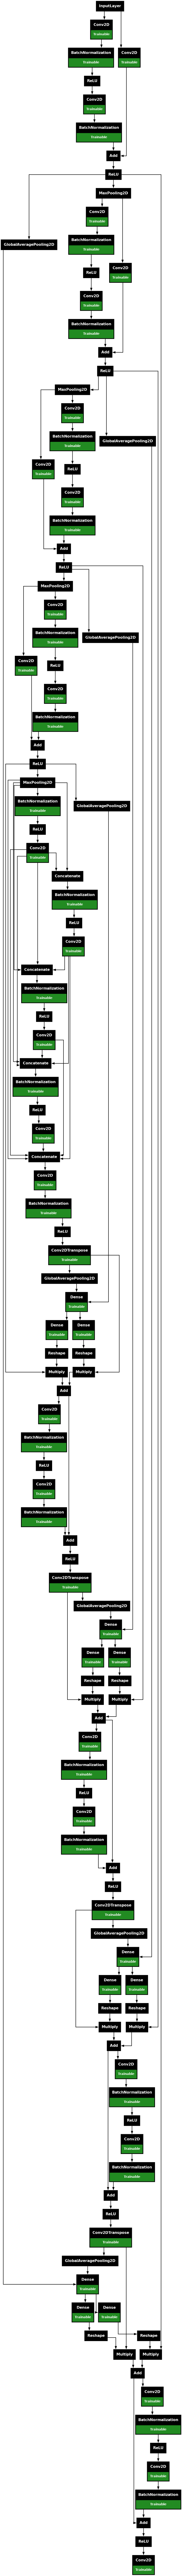

In [29]:
from focal_loss import SparseCategoricalFocalLoss

def residual_block(x, filters, kernel_size=3):
    """Residual block with batch normalization"""
    shortcut = x
    
    # If dimensions don't match, adjust shortcut path
    if shortcut.shape[-1] != filters:
        shortcut = tfkl.Conv2D(filters, 1, padding='same')(shortcut)
    
    # Main path
    x = tfkl.Conv2D(filters, kernel_size, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)
    x = tfkl.Conv2D(filters, kernel_size, padding='same')(x)
    x = tfkl.BatchNormalization()(x)
    
    # Add shortcut
    x = tfkl.Add()([x, shortcut])
    x = tfkl.ReLU()(x)
    
    return x

def dense_block(x, filters, num_layers=4):
    """Dense block with growth rate"""
    concat_layers = [x]
    
    for _ in range(num_layers):
        x = tfkl.BatchNormalization()(x)
        x = tfkl.ReLU()(x)
        x = tfkl.Conv2D(filters, 3, padding='same')(x)
        concat_layers.append(x)
        x = tfkl.Concatenate()(concat_layers)
    
    return x

def fusion_block(x1, x2):
    """Adaptive fusion of two feature maps using trainable gates."""
    # Get the number of channels
    channels = x1.shape[-1]
    
    # Global average pooling to capture global context
    g1 = tfkl.GlobalAveragePooling2D()(x1)
    g2 = tfkl.GlobalAveragePooling2D()(x2)
    
    # Shared fully connected layer
    shared_dense = tfkl.Dense(channels // 8, activation='relu')
    
    s1 = shared_dense(g1)
    s2 = shared_dense(g2)
    
    # Compute gates
    gate1 = tfkl.Dense(channels, activation='sigmoid')(s1)
    gate2 = tfkl.Dense(channels, activation='sigmoid')(s2)
    
    # Reshape gates
    gate1 = tfkl.Reshape((1, 1, channels))(gate1)
    gate2 = tfkl.Reshape((1, 1, channels))(gate2)
    
    # Weighted sum of the inputs
    out = gate1 * x1 + gate2 * x2
    return out

# Modified network architecture:
inputs = tfkl.Input(shape=input_shape)

# Encoder with residual blocks
c1 = residual_block(inputs, 16)
p1 = tfkl.MaxPooling2D((2, 2))(c1)

c2 = residual_block(p1, 32)
p2 = tfkl.MaxPooling2D((2, 2))(c2)

c3 = residual_block(p2, 64)
p3 = tfkl.MaxPooling2D((2, 2))(c3)

c4 = residual_block(p3, 128)
p4 = tfkl.MaxPooling2D((2, 2))(c4)

# Enhanced bottleneck with dense connections
c5 = dense_block(p4, 256)
c5 = tfkl.Conv2D(256, 1)(c5)  # 1x1 conv to reduce channels
c5 = tfkl.BatchNormalization()(c5)
c5 = tfkl.ReLU()(c5)

# Modified decoder path with fusion blocks
u6 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = fusion_block(u6, c4)
u6 = residual_block(u6, 128)

u7 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(u6)
u7 = fusion_block(u7, c3)
u7 = residual_block(u7, 64)

u8 = tfkl.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(u7)
u8 = fusion_block(u8, c2)
u8 = residual_block(u8, 32)

u9 = tfkl.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(u8)
u9 = fusion_block(u9, c1)
u9 = residual_block(u9, 16)

outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(u9)

model = tfk.Model(inputs=inputs, outputs=outputs, name="ResUnetWithFusion")

# Define the MeanIoU ignoring the background class
mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False)

model.compile(
    loss=SparseCategoricalFocalLoss(gamma=1, class_weight=final_class_weights_tensor, from_logits=False),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)

model.summary()
tf.keras.utils.plot_model(model, show_trainable=True, expand_nested=True, dpi=70)

In [30]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_iou',
    mode='max',
    patience=PATIENCE,  
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_iou',  # Metric to monitor
    factor=0.5,              # Factor by which the learning rate will be reduced
    patience=10,             # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,             # Lower bound on the learning rate
    verbose=1                # Verbosity mode
)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            image, label = load_single_image(self.image, self.label)
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = create_segmentation_colormap(num_classes)

            plt.figure(figsize=(16, 4))
            plt.suptitle(f"Epoch {epoch + 1}")

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label.numpy(), colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

vizcallback = VizCallback(image=val_img[0], label=val_lbl[0], frequency=5)

Epoch 1/500


I0000 00:00:1733908334.294015      67 service.cc:145] XLA service 0x7b7ce0002070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733908334.294091      67 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 3/60 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2009 - loss: 1.2961 - mean_iou: 0.0790  

I0000 00:00:1733908351.503729      67 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.2722 - loss: 0.8557 - mean_iou: 0.1327

I0000 00:00:1733908367.935416      68 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_15', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_4', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'loop_add_divide_multiply_subtract_fusion_14', 16 bytes spill stores, 16 bytes spill loads

W0000 00:00:1733908372.016221      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_focal_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733908374.784278      67 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_focal_loss/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Saved plot to img/006_Epoch_1.pdf


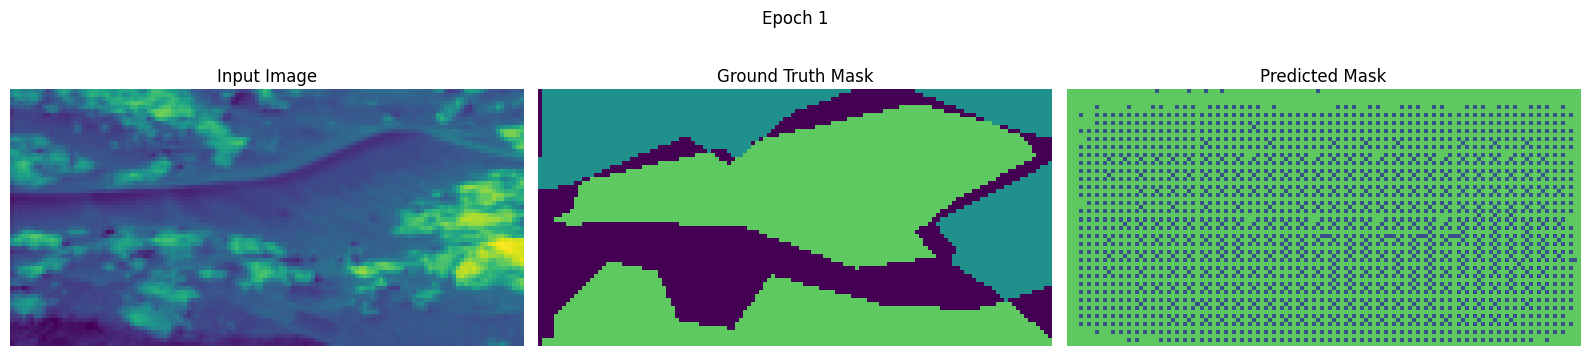

60/60 ━━━━━━━━━━━━━━━━━━━━ 64s 489ms/step - accuracy: 0.2727 - loss: 0.8529 - mean_iou: 0.1331 - val_accuracy: 0.2228 - val_loss: 0.7731 - val_mean_iou: 0.1059 - learning_rate: 0.0010
Epoch 2/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.3726 - loss: 0.4946 - mean_iou: 0.2486 - val_accuracy: 0.2331 - val_loss: 3.1409 - val_mean_iou: 0.1144 - learning_rate: 0.0010
Epoch 3/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4204 - loss: 0.4419 - mean_iou: 0.2946 - val_accuracy: 0.1981 - val_loss: 5.4228 - val_mean_iou: 0.0841 - learning_rate: 0.0010
Epoch 4/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.4744 - loss: 0.4007 - mean_iou: 0.3473 - val_accuracy: 0.1807 - val_loss: 2.9389 - val_mean_iou: 0.0598 - learning_rate: 0.0010
Epoch 5/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.5026 - loss: 0.3819 - mean_iou: 0.3737 - val_accuracy: 0.1808 - val_loss: 1.1354 - val_mean_iou: 0.0600 - learning_rate: 0.0010
Epoch 6/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0

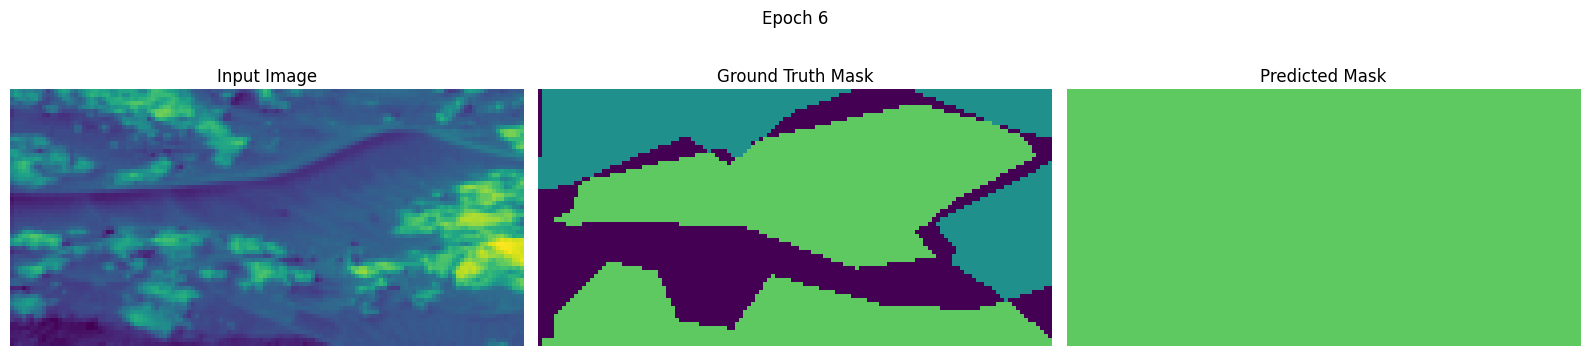

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.5292 - loss: 0.3553 - mean_iou: 0.4020 - val_accuracy: 0.1807 - val_loss: 2.2407 - val_mean_iou: 0.0598 - learning_rate: 0.0010
Epoch 7/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.5406 - loss: 0.3355 - mean_iou: 0.4160 - val_accuracy: 0.1848 - val_loss: 1.7688 - val_mean_iou: 0.0637 - learning_rate: 0.0010
Epoch 8/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.5442 - loss: 0.3367 - mean_iou: 0.4249 - val_accuracy: 0.2389 - val_loss: 1.3055 - val_mean_iou: 0.1179 - learning_rate: 0.0010
Epoch 9/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.5914 - loss: 0.2856 - mean_iou: 0.4785 - val_accuracy: 0.3934 - val_loss: 0.5062 - val_mean_iou: 0.2613 - learning_rate: 0.0010
Epoch 10/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6020 - loss: 0.2719 - mean_iou: 0.4920 - val_accuracy: 0.5230 - val_loss: 0.4614 - val_mean_iou: 0.3840 - learning_rate: 0.0010
Epoch 11/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0

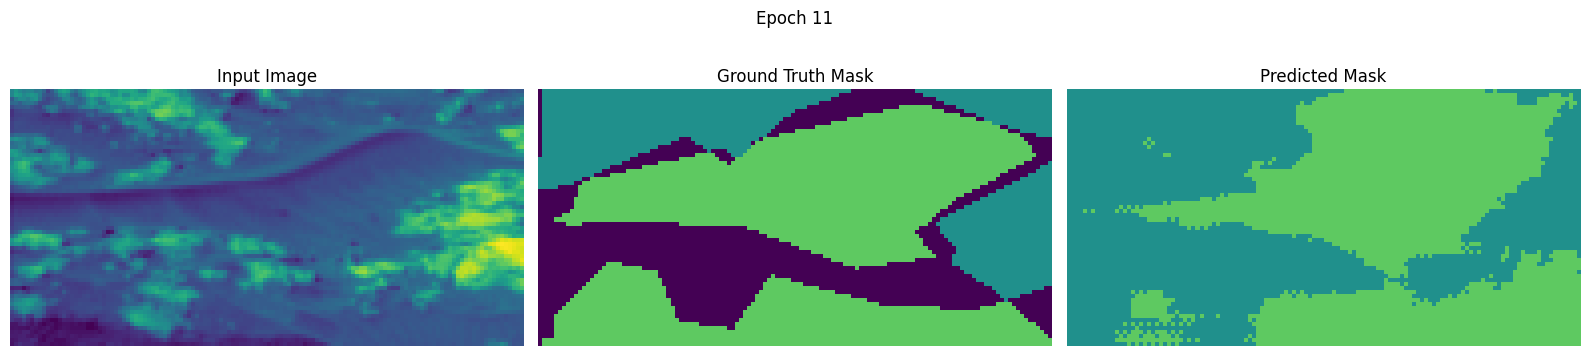

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.5960 - loss: 0.2920 - mean_iou: 0.4809 - val_accuracy: 0.4306 - val_loss: 0.5891 - val_mean_iou: 0.2859 - learning_rate: 0.0010
Epoch 12/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6024 - loss: 0.2743 - mean_iou: 0.4926 - val_accuracy: 0.5739 - val_loss: 0.2928 - val_mean_iou: 0.4560 - learning_rate: 0.0010
Epoch 13/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6067 - loss: 0.2612 - mean_iou: 0.5012 - val_accuracy: 0.5847 - val_loss: 0.2720 - val_mean_iou: 0.4829 - learning_rate: 0.0010
Epoch 14/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6119 - loss: 0.2573 - mean_iou: 0.5096
Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6120 - loss: 0.2568 - mean_iou: 0.5100 - val_accuracy: 0.5686 - val_loss: 0.3642 - val_mean_iou: 0.4528 - learning_rate: 0.0010
Epoch 15/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy

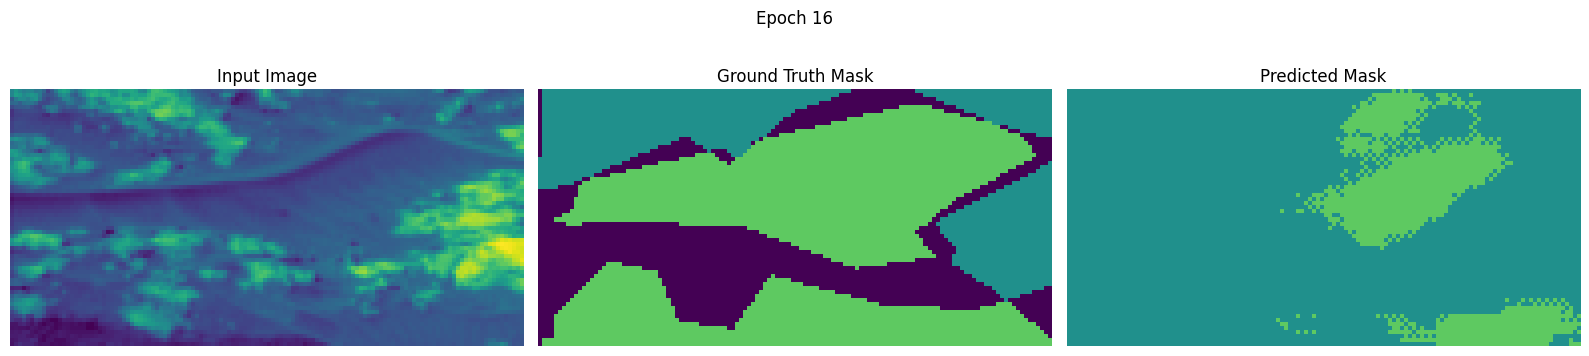

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6312 - loss: 0.2239 - mean_iou: 0.5468 - val_accuracy: 0.5921 - val_loss: 0.2930 - val_mean_iou: 0.4886 - learning_rate: 5.0000e-04
Epoch 17/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6192 - loss: 0.2298 - mean_iou: 0.5396 - val_accuracy: 0.5716 - val_loss: 0.3374 - val_mean_iou: 0.4673 - learning_rate: 5.0000e-04
Epoch 18/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6357 - loss: 0.2093 - mean_iou: 0.5627 - val_accuracy: 0.6507 - val_loss: 0.1997 - val_mean_iou: 0.5658 - learning_rate: 5.0000e-04
Epoch 19/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6355 - loss: 0.2155 - mean_iou: 0.5577 - val_accuracy: 0.5654 - val_loss: 0.3045 - val_mean_iou: 0.4694 - learning_rate: 5.0000e-04
Epoch 20/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6340 - loss: 0.2177 - mean_iou: 0.5519 - val_accuracy: 0.4866 - val_loss: 0.5369 - val_mean_iou: 0.3690 - learning_rate: 5.0000e-04
Epoch 21/500
59/60

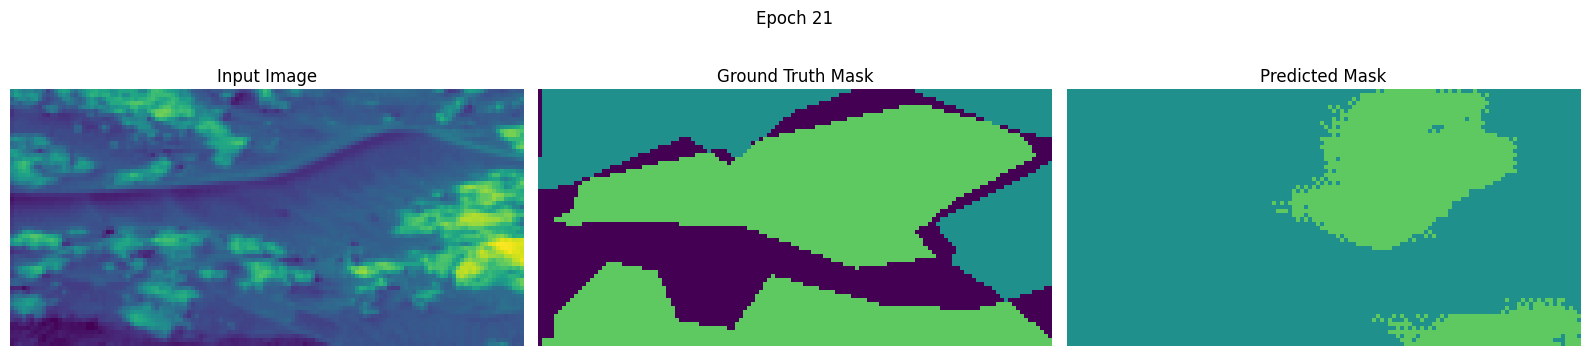

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6458 - loss: 0.2011 - mean_iou: 0.5735 - val_accuracy: 0.6032 - val_loss: 0.2544 - val_mean_iou: 0.5076 - learning_rate: 5.0000e-04
Epoch 22/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6463 - loss: 0.1962 - mean_iou: 0.5665 - val_accuracy: 0.5999 - val_loss: 0.2691 - val_mean_iou: 0.4971 - learning_rate: 5.0000e-04
Epoch 23/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6478 - loss: 0.2002 - mean_iou: 0.5814 - val_accuracy: 0.5365 - val_loss: 0.3835 - val_mean_iou: 0.4293 - learning_rate: 5.0000e-04
Epoch 24/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6387 - loss: 0.1950 - mean_iou: 0.5714
Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6390 - loss: 0.1945 - mean_iou: 0.5720 - val_accuracy: 0.5832 - val_loss: 0.3193 - val_mean_iou: 0.4803 - learning_rate: 5.0000e-04
Epoch 25/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms

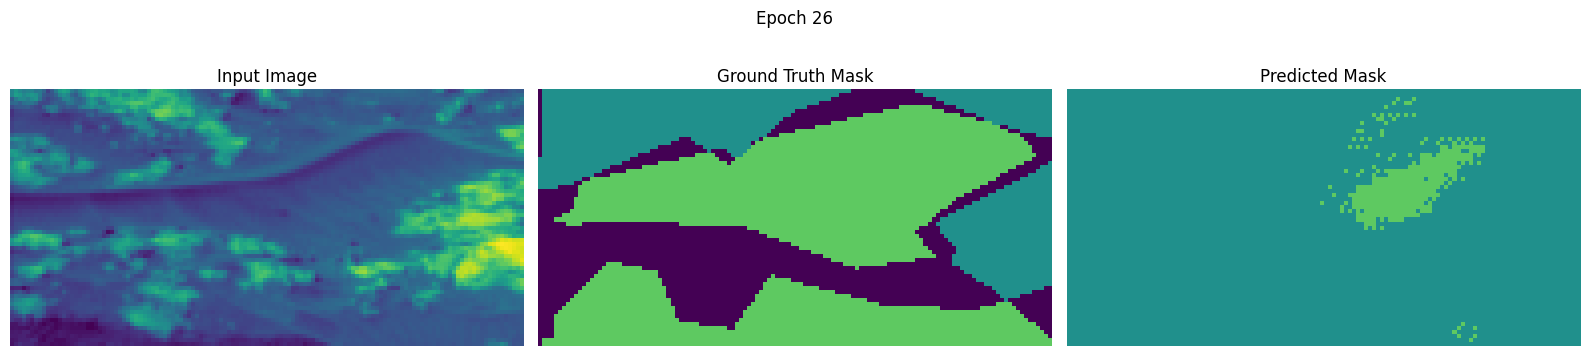

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6586 - loss: 0.1698 - mean_iou: 0.5936 - val_accuracy: 0.6360 - val_loss: 0.1982 - val_mean_iou: 0.5575 - learning_rate: 2.5000e-04
Epoch 27/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - accuracy: 0.6584 - loss: 0.1744 - mean_iou: 0.6043 - val_accuracy: 0.6632 - val_loss: 0.1644 - val_mean_iou: 0.5884 - learning_rate: 2.5000e-04
Epoch 28/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6555 - loss: 0.1676 - mean_iou: 0.6004 - val_accuracy: 0.6200 - val_loss: 0.1994 - val_mean_iou: 0.5343 - learning_rate: 2.5000e-04
Epoch 29/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6629 - loss: 0.1577 - mean_iou: 0.6086 - val_accuracy: 0.6374 - val_loss: 0.2072 - val_mean_iou: 0.5574 - learning_rate: 2.5000e-04
Epoch 30/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6614 - loss: 0.1577 - mean_iou: 0.6071 - val_accuracy: 0.6433 - val_loss: 0.2013 - val_mean_iou: 0.5590 - learning_rate: 2.5000e-04
Epoch 31/500
59/60

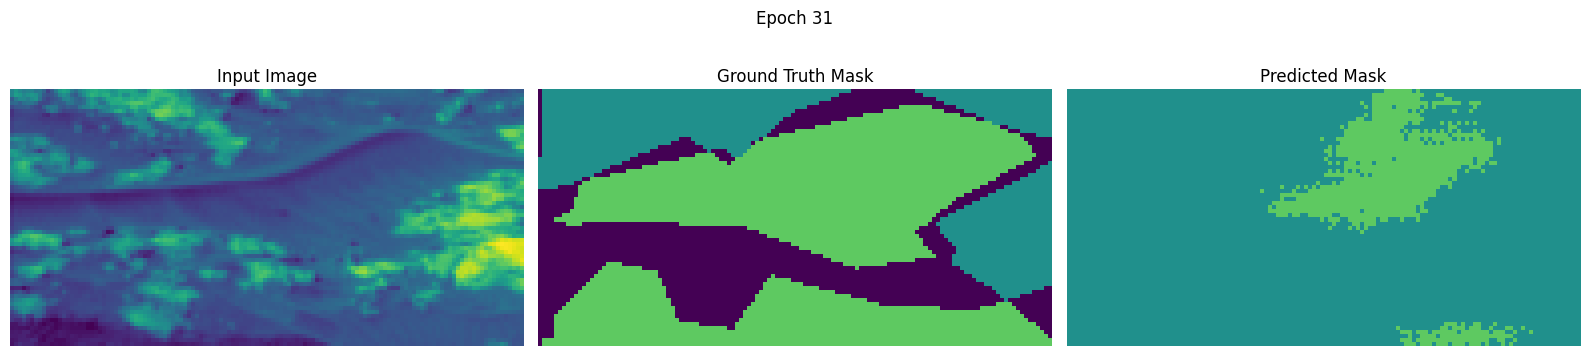

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6631 - loss: 0.1605 - mean_iou: 0.6157 - val_accuracy: 0.5880 - val_loss: 0.2816 - val_mean_iou: 0.4860 - learning_rate: 2.5000e-04
Epoch 32/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6655 - loss: 0.1568 - mean_iou: 0.6130 - val_accuracy: 0.6577 - val_loss: 0.1629 - val_mean_iou: 0.5843 - learning_rate: 2.5000e-04
Epoch 33/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6703 - loss: 0.1558 - mean_iou: 0.6305 - val_accuracy: 0.6504 - val_loss: 0.1907 - val_mean_iou: 0.5712 - learning_rate: 2.5000e-04
Epoch 34/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6600 - loss: 0.1552 - mean_iou: 0.6117
Epoch 34: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6601 - loss: 0.1550 - mean_iou: 0.6119 - val_accuracy: 0.6526 - val_loss: 0.1978 - val_mean_iou: 0.5742 - learning_rate: 2.5000e-04
Epoch 35/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms

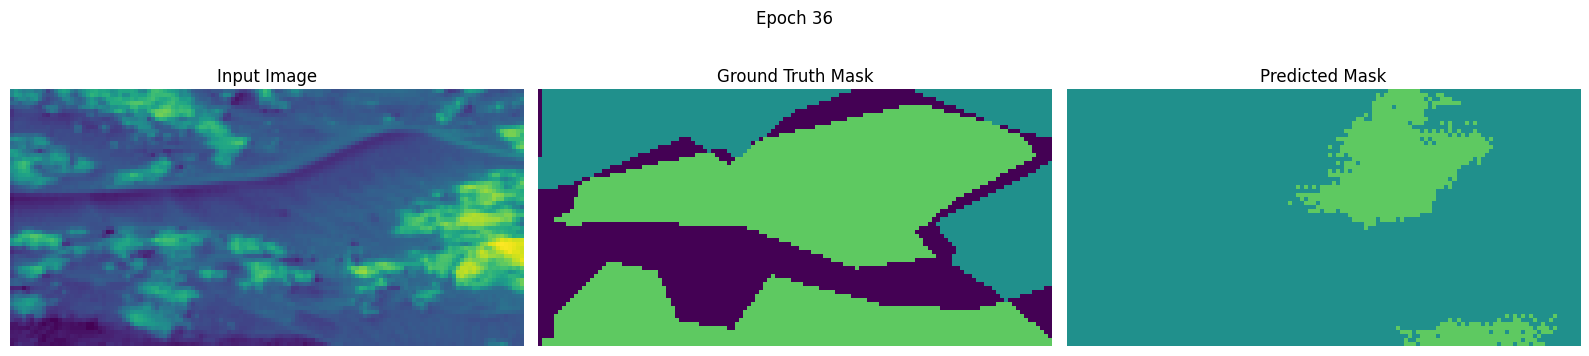

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6699 - loss: 0.1561 - mean_iou: 0.6242 - val_accuracy: 0.6672 - val_loss: 0.1550 - val_mean_iou: 0.5963 - learning_rate: 1.2500e-04
Epoch 37/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6730 - loss: 0.1426 - mean_iou: 0.6280 - val_accuracy: 0.6810 - val_loss: 0.1353 - val_mean_iou: 0.6176 - learning_rate: 1.2500e-04
Epoch 38/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6689 - loss: 0.1435 - mean_iou: 0.6241 - val_accuracy: 0.6928 - val_loss: 0.1306 - val_mean_iou: 0.6467 - learning_rate: 1.2500e-04
Epoch 39/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6747 - loss: 0.1369 - mean_iou: 0.6325 - val_accuracy: 0.6996 - val_loss: 0.1266 - val_mean_iou: 0.6565 - learning_rate: 1.2500e-04
Epoch 40/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6779 - loss: 0.1359 - mean_iou: 0.6510 - val_accuracy: 0.6635 - val_loss: 0.1479 - val_mean_iou: 0.6209 - learning_rate: 1.2500e-04
Epoch 41/500
59/60

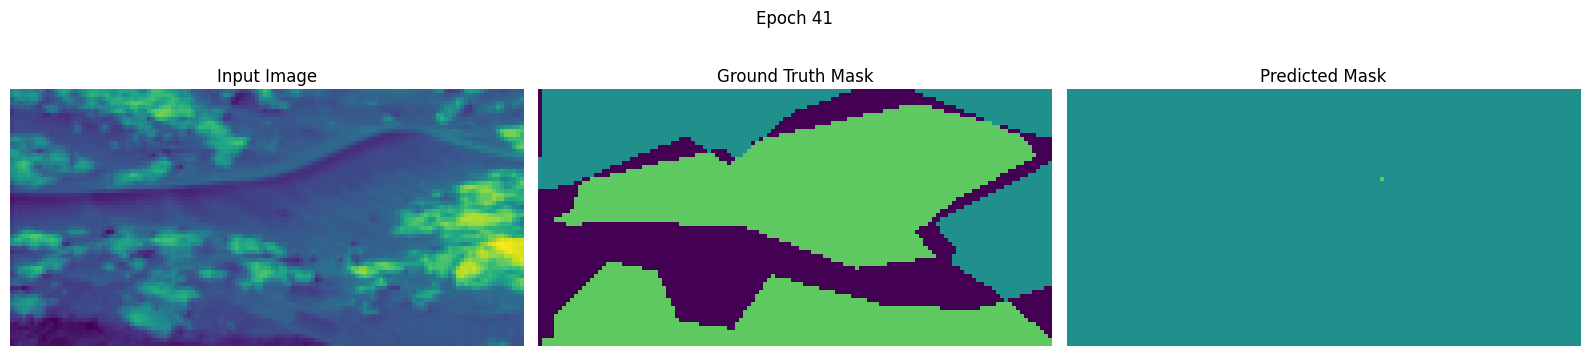

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6712 - loss: 0.1375 - mean_iou: 0.6262 - val_accuracy: 0.6571 - val_loss: 0.1731 - val_mean_iou: 0.5805 - learning_rate: 1.2500e-04
Epoch 42/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6749 - loss: 0.1313 - mean_iou: 0.6536 - val_accuracy: 0.6941 - val_loss: 0.1310 - val_mean_iou: 0.6416 - learning_rate: 1.2500e-04
Epoch 43/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6856 - loss: 0.1208 - mean_iou: 0.6584 - val_accuracy: 0.6639 - val_loss: 0.1633 - val_mean_iou: 0.5887 - learning_rate: 1.2500e-04
Epoch 44/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6798 - loss: 0.1231 - mean_iou: 0.6579
Epoch 44: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6797 - loss: 0.1231 - mean_iou: 0.6580 - val_accuracy: 0.6708 - val_loss: 0.1396 - val_mean_iou: 0.6044 - learning_rate: 1.2500e-04
Epoch 45/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/

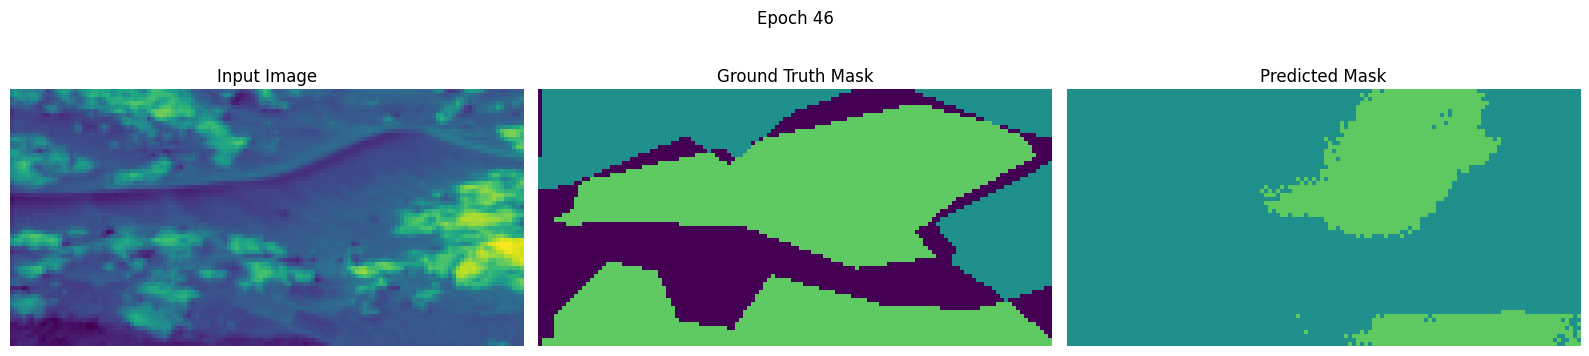

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 0.6792 - loss: 0.1278 - mean_iou: 0.6628 - val_accuracy: 0.6889 - val_loss: 0.1165 - val_mean_iou: 0.6544 - learning_rate: 6.2500e-05
Epoch 47/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6812 - loss: 0.1221 - mean_iou: 0.6607 - val_accuracy: 0.6915 - val_loss: 0.1171 - val_mean_iou: 0.6570 - learning_rate: 6.2500e-05
Epoch 48/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6830 - loss: 0.1193 - mean_iou: 0.6578 - val_accuracy: 0.6865 - val_loss: 0.1157 - val_mean_iou: 0.6490 - learning_rate: 6.2500e-05
Epoch 49/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6883 - loss: 0.1171 - mean_iou: 0.6710 - val_accuracy: 0.6888 - val_loss: 0.1222 - val_mean_iou: 0.6426 - learning_rate: 6.2500e-05
Epoch 50/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6861 - loss: 0.1202 - mean_iou: 0.6697 - val_accuracy: 0.6849 - val_loss: 0.1223 - val_mean_iou: 0.6497 - learning_rate: 6.2500e-05
Epoch 51/500
60/60

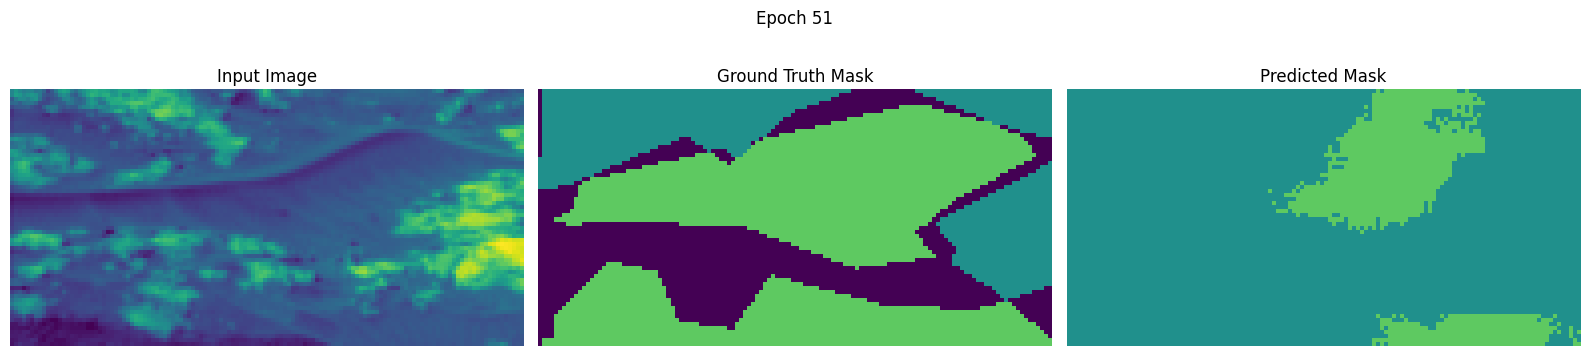

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6855 - loss: 0.1150 - mean_iou: 0.6803 - val_accuracy: 0.6854 - val_loss: 0.1201 - val_mean_iou: 0.6456 - learning_rate: 6.2500e-05
Epoch 52/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6891 - loss: 0.1169 - mean_iou: 0.6721 - val_accuracy: 0.6959 - val_loss: 0.1240 - val_mean_iou: 0.6615 - learning_rate: 6.2500e-05
Epoch 53/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6860 - loss: 0.1177 - mean_iou: 0.6777 - val_accuracy: 0.6894 - val_loss: 0.1269 - val_mean_iou: 0.6340 - learning_rate: 6.2500e-05
Epoch 54/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6920 - loss: 0.1106 - mean_iou: 0.6915
Epoch 54: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6920 - loss: 0.1106 - mean_iou: 0.6914 - val_accuracy: 0.6937 - val_loss: 0.1246 - val_mean_iou: 0.6538 - learning_rate: 6.2500e-05
Epoch 55/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms

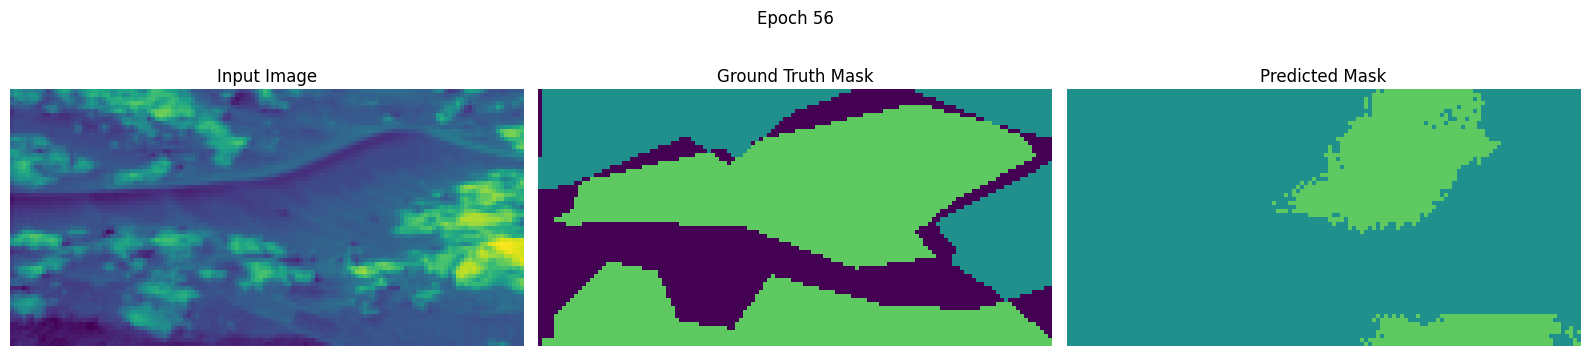

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6893 - loss: 0.1112 - mean_iou: 0.6804 - val_accuracy: 0.6907 - val_loss: 0.1168 - val_mean_iou: 0.6545 - learning_rate: 3.1250e-05
Epoch 57/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6893 - loss: 0.1098 - mean_iou: 0.6899 - val_accuracy: 0.6956 - val_loss: 0.1188 - val_mean_iou: 0.6513 - learning_rate: 3.1250e-05
Epoch 58/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6807 - loss: 0.1125 - mean_iou: 0.6963 - val_accuracy: 0.6954 - val_loss: 0.1158 - val_mean_iou: 0.6546 - learning_rate: 3.1250e-05
Epoch 59/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6889 - loss: 0.1108 - mean_iou: 0.6863 - val_accuracy: 0.6903 - val_loss: 0.1157 - val_mean_iou: 0.6448 - learning_rate: 3.1250e-05
Epoch 60/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6883 - loss: 0.1124 - mean_iou: 0.7107 - val_accuracy: 0.6913 - val_loss: 0.1159 - val_mean_iou: 0.6532 - learning_rate: 3.1250e-05
Epoch 61/500
60/60

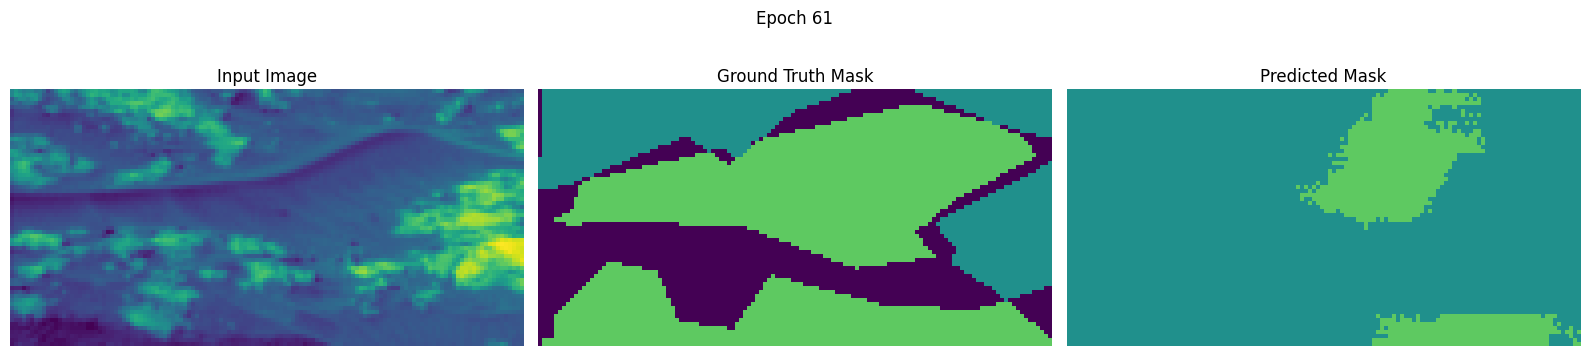

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6861 - loss: 0.1144 - mean_iou: 0.6797 - val_accuracy: 0.6918 - val_loss: 0.1194 - val_mean_iou: 0.6581 - learning_rate: 3.1250e-05
Epoch 62/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6919 - loss: 0.1066 - mean_iou: 0.6893 - val_accuracy: 0.6927 - val_loss: 0.1153 - val_mean_iou: 0.6523 - learning_rate: 3.1250e-05
Epoch 63/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6835 - loss: 0.1105 - mean_iou: 0.6807 - val_accuracy: 0.6854 - val_loss: 0.1191 - val_mean_iou: 0.6428 - learning_rate: 3.1250e-05
Epoch 64/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6913 - loss: 0.1041 - mean_iou: 0.7157
Epoch 64: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6914 - loss: 0.1040 - mean_iou: 0.7157 - val_accuracy: 0.6960 - val_loss: 0.1156 - val_mean_iou: 0.6629 - learning_rate: 3.1250e-05
Epoch 65/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52m

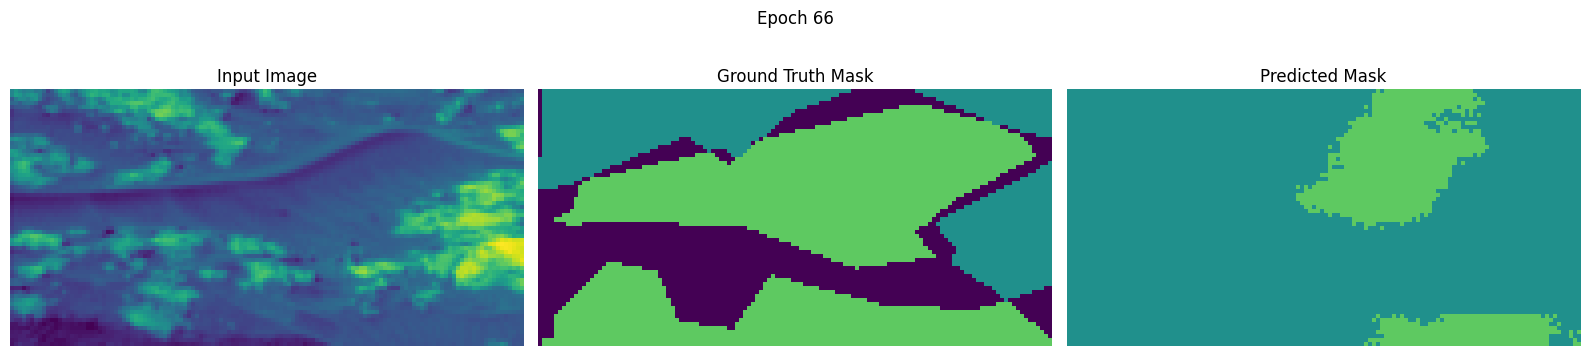

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6920 - loss: 0.1033 - mean_iou: 0.7051 - val_accuracy: 0.6869 - val_loss: 0.1188 - val_mean_iou: 0.6492 - learning_rate: 1.5625e-05
Epoch 67/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6883 - loss: 0.1097 - mean_iou: 0.6809 - val_accuracy: 0.6989 - val_loss: 0.1180 - val_mean_iou: 0.6638 - learning_rate: 1.5625e-05
Epoch 68/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6932 - loss: 0.1019 - mean_iou: 0.7026 - val_accuracy: 0.6953 - val_loss: 0.1178 - val_mean_iou: 0.6598 - learning_rate: 1.5625e-05
Epoch 69/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6921 - loss: 0.1056 - mean_iou: 0.7128 - val_accuracy: 0.6955 - val_loss: 0.1173 - val_mean_iou: 0.6591 - learning_rate: 1.5625e-05
Epoch 70/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6902 - loss: 0.1041 - mean_iou: 0.7197 - val_accuracy: 0.6938 - val_loss: 0.1169 - val_mean_iou: 0.6604 - learning_rate: 1.5625e-05
Epoch 71/500
60/60

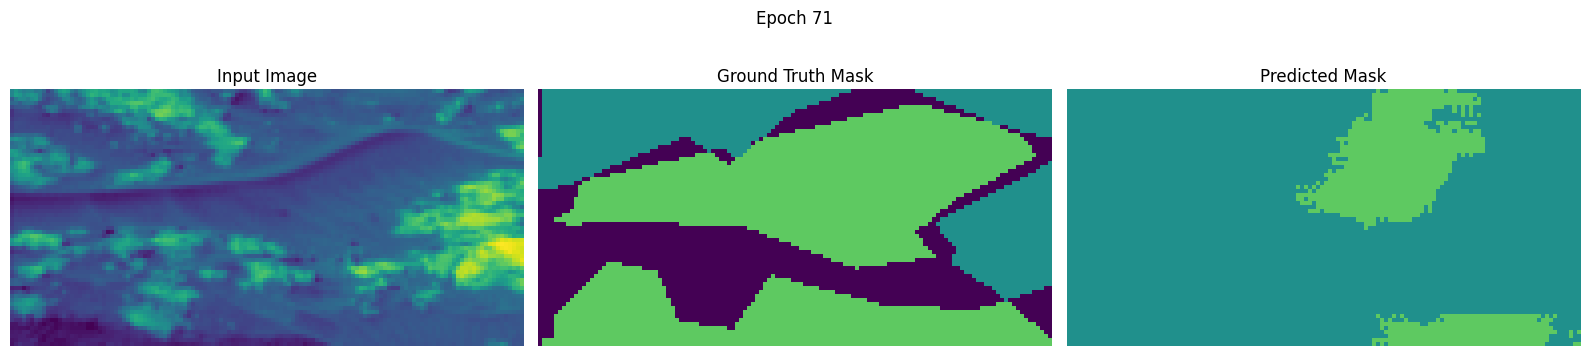

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6933 - loss: 0.1062 - mean_iou: 0.6926 - val_accuracy: 0.6916 - val_loss: 0.1184 - val_mean_iou: 0.6582 - learning_rate: 1.5625e-05
Epoch 72/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6929 - loss: 0.1064 - mean_iou: 0.7113 - val_accuracy: 0.6953 - val_loss: 0.1186 - val_mean_iou: 0.6604 - learning_rate: 1.5625e-05
Epoch 73/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6981 - loss: 0.1010 - mean_iou: 0.6990 - val_accuracy: 0.6962 - val_loss: 0.1180 - val_mean_iou: 0.6615 - learning_rate: 1.5625e-05
Epoch 74/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6956 - loss: 0.1012 - mean_iou: 0.7002
Epoch 74: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6955 - loss: 0.1012 - mean_iou: 0.7005 - val_accuracy: 0.6969 - val_loss: 0.1172 - val_mean_iou: 0.6643 - learning_rate: 1.5625e-05
Epoch 75/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms

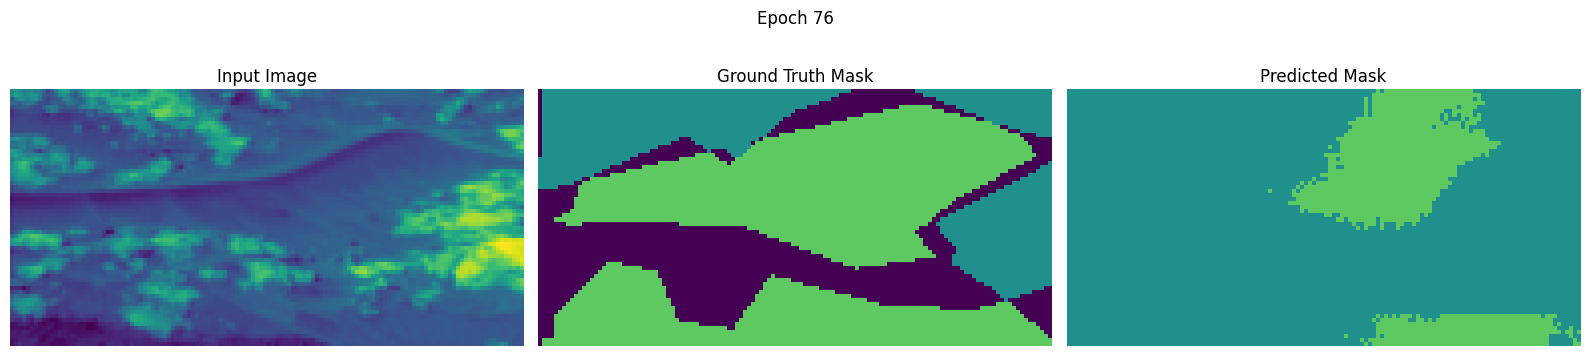

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6926 - loss: 0.1012 - mean_iou: 0.7133 - val_accuracy: 0.6935 - val_loss: 0.1162 - val_mean_iou: 0.6570 - learning_rate: 7.8125e-06
Epoch 77/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6930 - loss: 0.1065 - mean_iou: 0.7070 - val_accuracy: 0.6932 - val_loss: 0.1154 - val_mean_iou: 0.6583 - learning_rate: 7.8125e-06
Epoch 78/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6924 - loss: 0.1011 - mean_iou: 0.7256 - val_accuracy: 0.6946 - val_loss: 0.1141 - val_mean_iou: 0.6599 - learning_rate: 7.8125e-06
Epoch 79/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6905 - loss: 0.1085 - mean_iou: 0.6858 - val_accuracy: 0.6955 - val_loss: 0.1145 - val_mean_iou: 0.6609 - learning_rate: 7.8125e-06
Epoch 80/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6902 - loss: 0.1125 - mean_iou: 0.6908 - val_accuracy: 0.6949 - val_loss: 0.1157 - val_mean_iou: 0.6602 - learning_rate: 7.8125e-06
Epoch 81/500
60/60

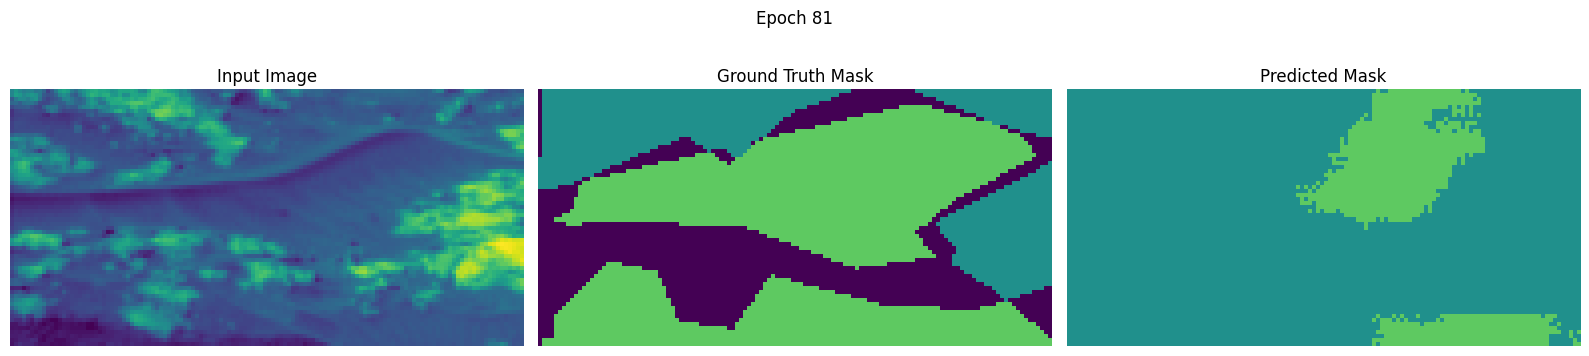

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6934 - loss: 0.1075 - mean_iou: 0.7043 - val_accuracy: 0.6938 - val_loss: 0.1152 - val_mean_iou: 0.6593 - learning_rate: 7.8125e-06
Epoch 82/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6885 - loss: 0.1095 - mean_iou: 0.6939 - val_accuracy: 0.6961 - val_loss: 0.1152 - val_mean_iou: 0.6620 - learning_rate: 7.8125e-06
Epoch 83/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6880 - loss: 0.1051 - mean_iou: 0.6864 - val_accuracy: 0.6954 - val_loss: 0.1151 - val_mean_iou: 0.6618 - learning_rate: 7.8125e-06
Epoch 84/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6933 - loss: 0.1039 - mean_iou: 0.7125
Epoch 84: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6933 - loss: 0.1039 - mean_iou: 0.7125 - val_accuracy: 0.6953 - val_loss: 0.1154 - val_mean_iou: 0.6616 - learning_rate: 7.8125e-06
Epoch 85/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms

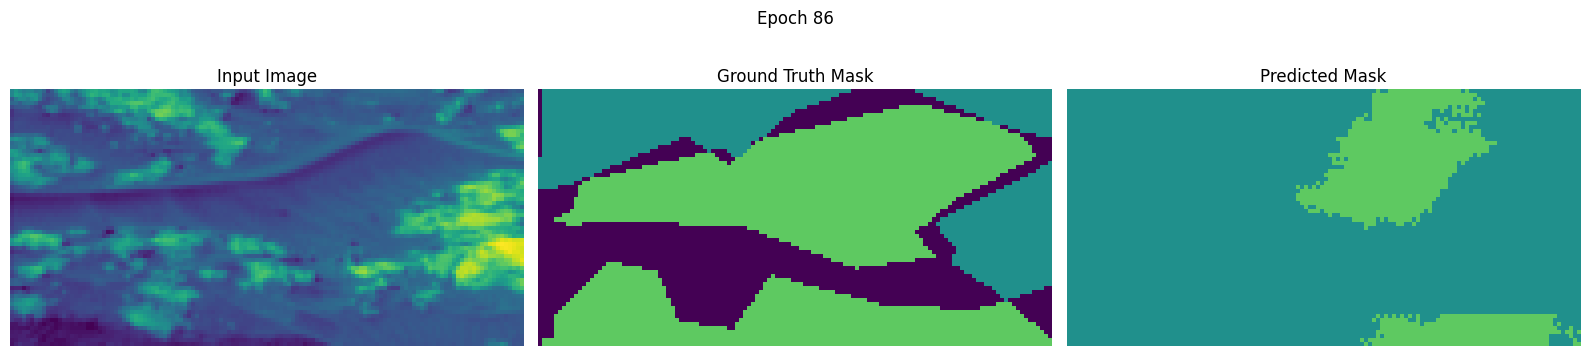

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6930 - loss: 0.1006 - mean_iou: 0.7154 - val_accuracy: 0.6955 - val_loss: 0.1155 - val_mean_iou: 0.6618 - learning_rate: 3.9063e-06
Epoch 87/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6916 - loss: 0.1036 - mean_iou: 0.7100 - val_accuracy: 0.6958 - val_loss: 0.1154 - val_mean_iou: 0.6623 - learning_rate: 3.9063e-06
Epoch 88/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6923 - loss: 0.1035 - mean_iou: 0.7073 - val_accuracy: 0.6954 - val_loss: 0.1153 - val_mean_iou: 0.6623 - learning_rate: 3.9063e-06
Epoch 89/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6891 - loss: 0.1061 - mean_iou: 0.7145 - val_accuracy: 0.6946 - val_loss: 0.1154 - val_mean_iou: 0.6603 - learning_rate: 3.9063e-06
Epoch 90/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6912 - loss: 0.1042 - mean_iou: 0.7070 - val_accuracy: 0.6949 - val_loss: 0.1154 - val_mean_iou: 0.6614 - learning_rate: 3.9063e-06
Epoch 91/500
60/60

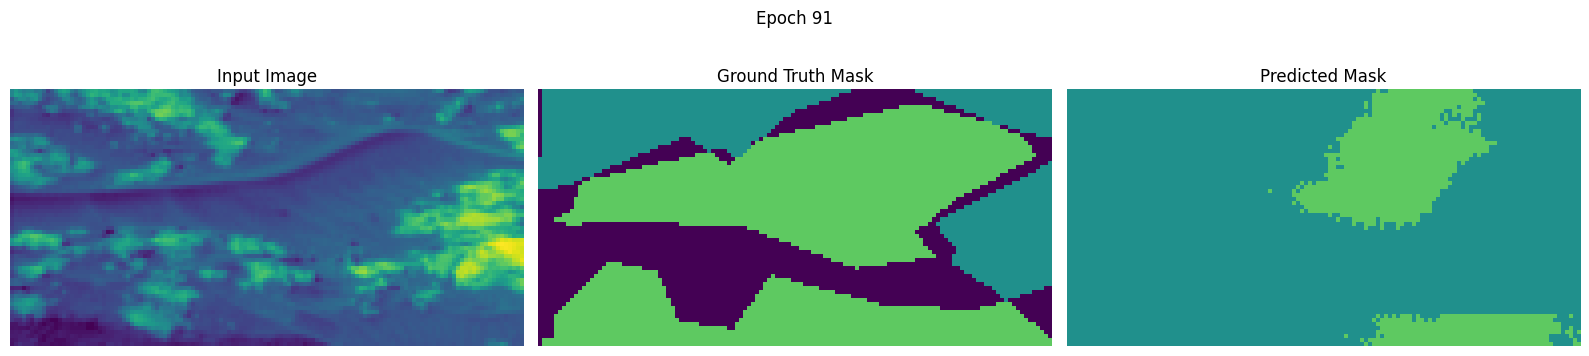

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6962 - loss: 0.1024 - mean_iou: 0.7019 - val_accuracy: 0.6949 - val_loss: 0.1155 - val_mean_iou: 0.6615 - learning_rate: 3.9063e-06
Epoch 92/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6923 - loss: 0.1025 - mean_iou: 0.7123 - val_accuracy: 0.6979 - val_loss: 0.1159 - val_mean_iou: 0.6659 - learning_rate: 3.9063e-06
Epoch 93/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6869 - loss: 0.1082 - mean_iou: 0.7016 - val_accuracy: 0.6970 - val_loss: 0.1154 - val_mean_iou: 0.6637 - learning_rate: 3.9063e-06
Epoch 94/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.6884 - loss: 0.1028 - mean_iou: 0.7047
Epoch 94: ReduceLROnPlateau reducing learning rate to 1.9531250927684596e-06.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6885 - loss: 0.1027 - mean_iou: 0.7051 - val_accuracy: 0.6959 - val_loss: 0.1152 - val_mean_iou: 0.6624 - learning_rate: 3.9063e-06
Epoch 95/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54m

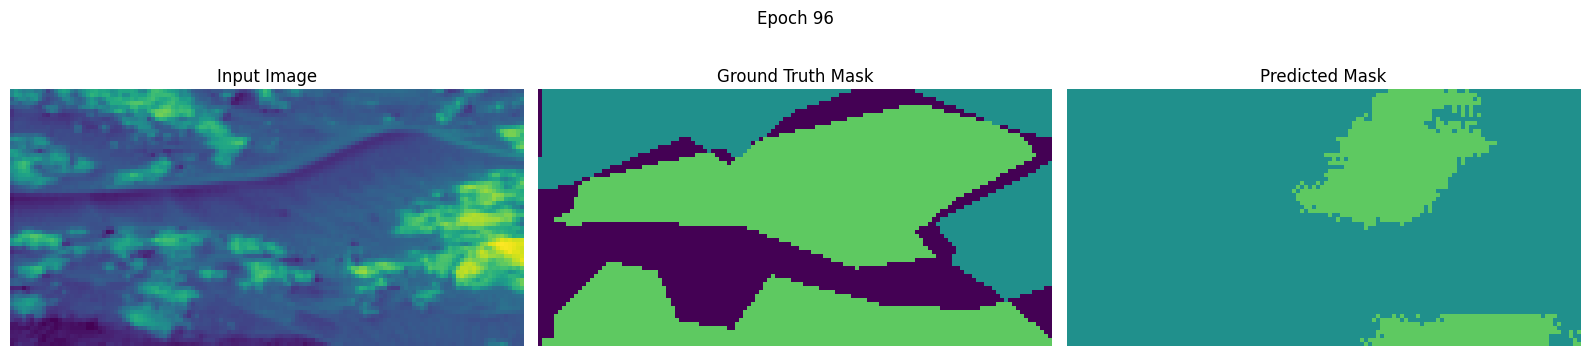

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.7003 - loss: 0.0924 - mean_iou: 0.7354 - val_accuracy: 0.6958 - val_loss: 0.1150 - val_mean_iou: 0.6618 - learning_rate: 1.9531e-06
Epoch 97/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6918 - loss: 0.1007 - mean_iou: 0.7087 - val_accuracy: 0.6963 - val_loss: 0.1150 - val_mean_iou: 0.6626 - learning_rate: 1.9531e-06
Epoch 98/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6866 - loss: 0.1097 - mean_iou: 0.6962 - val_accuracy: 0.6962 - val_loss: 0.1147 - val_mean_iou: 0.6632 - learning_rate: 1.9531e-06
Epoch 99/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6955 - loss: 0.0964 - mean_iou: 0.7126 - val_accuracy: 0.6955 - val_loss: 0.1148 - val_mean_iou: 0.6616 - learning_rate: 1.9531e-06
Epoch 100/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6907 - loss: 0.0983 - mean_iou: 0.7090 - val_accuracy: 0.6954 - val_loss: 0.1149 - val_mean_iou: 0.6612 - learning_rate: 1.9531e-06
Epoch 101/500
59/

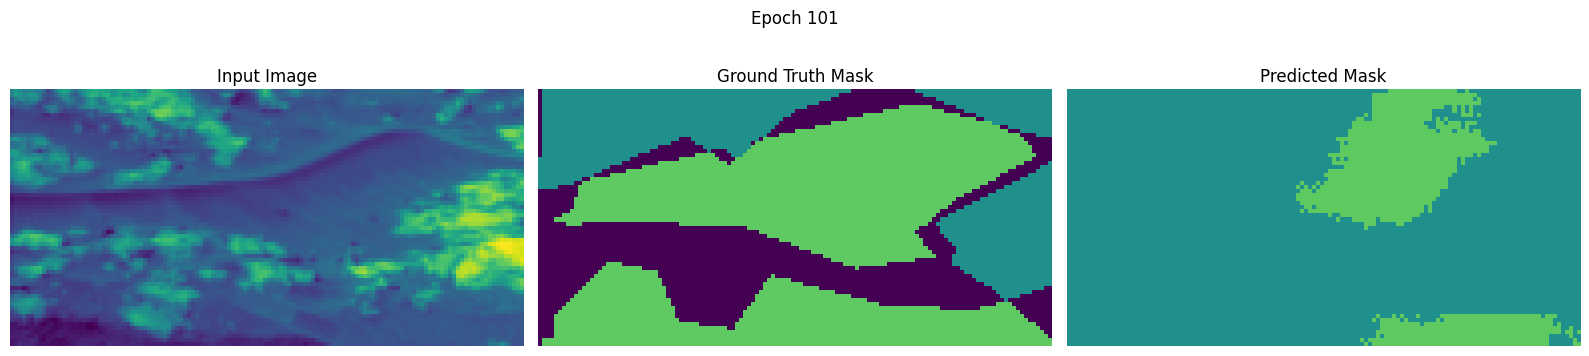

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6934 - loss: 0.1012 - mean_iou: 0.7170 - val_accuracy: 0.6948 - val_loss: 0.1150 - val_mean_iou: 0.6606 - learning_rate: 1.9531e-06
Epoch 102/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6987 - loss: 0.0971 - mean_iou: 0.7157 - val_accuracy: 0.6951 - val_loss: 0.1153 - val_mean_iou: 0.6610 - learning_rate: 1.9531e-06
Epoch 103/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6952 - loss: 0.1022 - mean_iou: 0.7034 - val_accuracy: 0.6957 - val_loss: 0.1152 - val_mean_iou: 0.6622 - learning_rate: 1.9531e-06
Epoch 104/500
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6945 - loss: 0.1051 - mean_iou: 0.7132
Epoch 104: ReduceLROnPlateau reducing learning rate to 1e-06.
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.6945 - loss: 0.1049 - mean_iou: 0.7134 - val_accuracy: 0.6959 - val_loss: 0.1151 - val_mean_iou: 0.6627 - learning_rate: 1.9531e-06
Epoch 105/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - acc

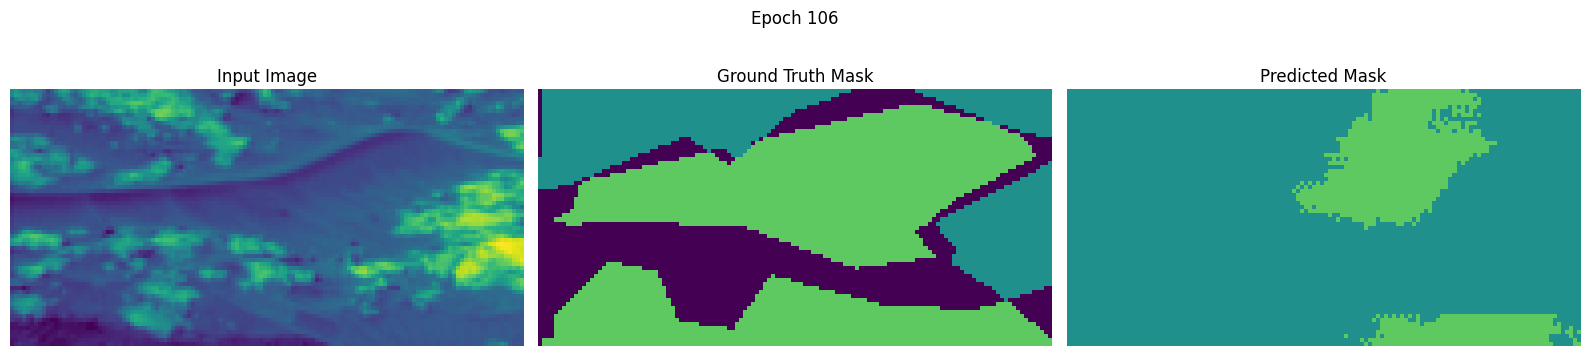

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6912 - loss: 0.1018 - mean_iou: 0.7074 - val_accuracy: 0.6955 - val_loss: 0.1151 - val_mean_iou: 0.6615 - learning_rate: 1.0000e-06
Epoch 107/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6933 - loss: 0.0980 - mean_iou: 0.7282 - val_accuracy: 0.6958 - val_loss: 0.1151 - val_mean_iou: 0.6617 - learning_rate: 1.0000e-06
Epoch 108/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6909 - loss: 0.1047 - mean_iou: 0.7062 - val_accuracy: 0.6957 - val_loss: 0.1151 - val_mean_iou: 0.6619 - learning_rate: 1.0000e-06
Epoch 109/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6952 - loss: 0.1043 - mean_iou: 0.6947 - val_accuracy: 0.6955 - val_loss: 0.1151 - val_mean_iou: 0.6620 - learning_rate: 1.0000e-06
Epoch 110/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6918 - loss: 0.1063 - mean_iou: 0.7106 - val_accuracy: 0.6954 - val_loss: 0.1151 - val_mean_iou: 0.6615 - learning_rate: 1.0000e-06
Epoch 111/500


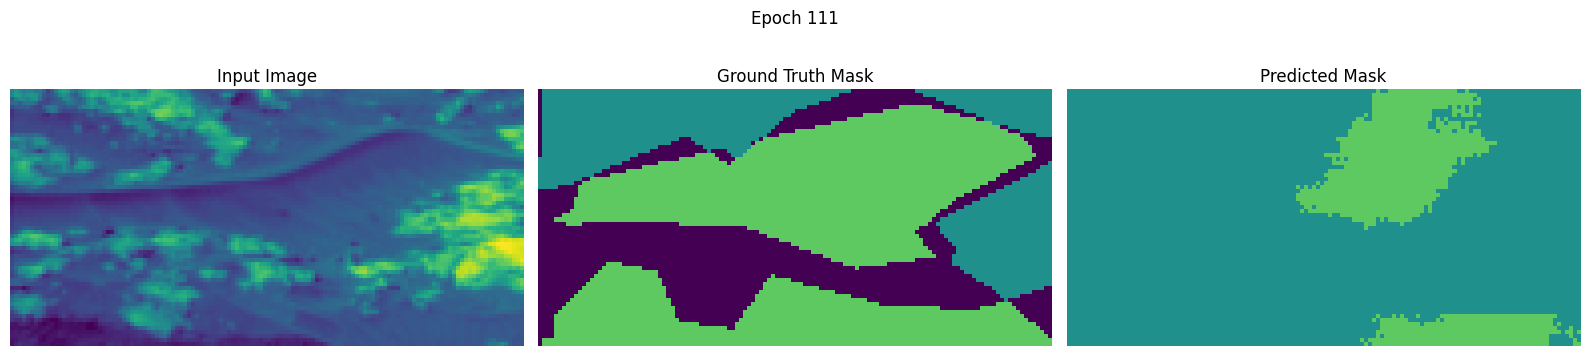

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.6994 - loss: 0.1027 - mean_iou: 0.7018 - val_accuracy: 0.6953 - val_loss: 0.1153 - val_mean_iou: 0.6614 - learning_rate: 1.0000e-06
Epoch 112/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7006 - loss: 0.0979 - mean_iou: 0.7330 - val_accuracy: 0.6953 - val_loss: 0.1150 - val_mean_iou: 0.6617 - learning_rate: 1.0000e-06
Epoch 113/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6959 - loss: 0.0965 - mean_iou: 0.7111 - val_accuracy: 0.6953 - val_loss: 0.1149 - val_mean_iou: 0.6615 - learning_rate: 1.0000e-06
Epoch 114/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - accuracy: 0.6979 - loss: 0.0966 - mean_iou: 0.7150 - val_accuracy: 0.6953 - val_loss: 0.1151 - val_mean_iou: 0.6612 - learning_rate: 1.0000e-06
Epoch 115/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6974 - loss: 0.1010 - mean_iou: 0.7082 - val_accuracy: 0.6949 - val_loss: 0.1150 - val_mean_iou: 0.6607 - learning_rate: 1.0000e-06
Epoch 116/500


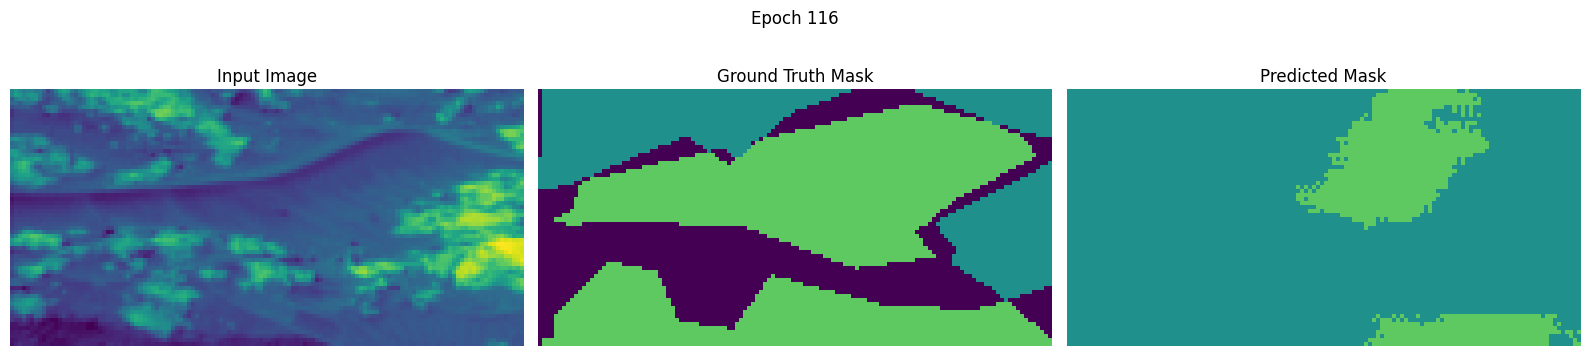

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6942 - loss: 0.1011 - mean_iou: 0.7092 - val_accuracy: 0.6953 - val_loss: 0.1151 - val_mean_iou: 0.6607 - learning_rate: 1.0000e-06
Epoch 117/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6915 - loss: 0.1002 - mean_iou: 0.7239 - val_accuracy: 0.6955 - val_loss: 0.1150 - val_mean_iou: 0.6614 - learning_rate: 1.0000e-06
Epoch 118/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6960 - loss: 0.0984 - mean_iou: 0.7260 - val_accuracy: 0.6956 - val_loss: 0.1151 - val_mean_iou: 0.6617 - learning_rate: 1.0000e-06
Epoch 119/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7001 - loss: 0.0954 - mean_iou: 0.7236 - val_accuracy: 0.6954 - val_loss: 0.1150 - val_mean_iou: 0.6615 - learning_rate: 1.0000e-06
Epoch 120/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6977 - loss: 0.1028 - mean_iou: 0.7007 - val_accuracy: 0.6957 - val_loss: 0.1150 - val_mean_iou: 0.6618 - learning_rate: 1.0000e-06
Epoch 121/500


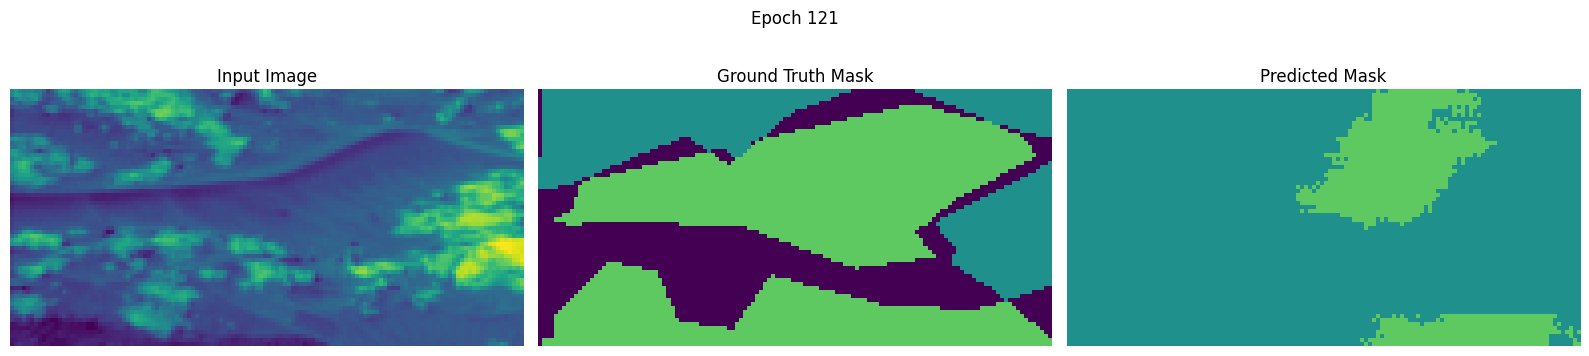

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - accuracy: 0.6958 - loss: 0.1040 - mean_iou: 0.7004 - val_accuracy: 0.6957 - val_loss: 0.1151 - val_mean_iou: 0.6618 - learning_rate: 1.0000e-06
Epoch 122/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6963 - loss: 0.0985 - mean_iou: 0.7193 - val_accuracy: 0.6955 - val_loss: 0.1153 - val_mean_iou: 0.6613 - learning_rate: 1.0000e-06
Epoch 123/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6965 - loss: 0.1012 - mean_iou: 0.7142 - val_accuracy: 0.6955 - val_loss: 0.1152 - val_mean_iou: 0.6615 - learning_rate: 1.0000e-06
Epoch 124/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.6905 - loss: 0.1068 - mean_iou: 0.7166 - val_accuracy: 0.6950 - val_loss: 0.1153 - val_mean_iou: 0.6611 - learning_rate: 1.0000e-06
Epoch 125/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7000 - loss: 0.1007 - mean_iou: 0.7183 - val_accuracy: 0.6950 - val_loss: 0.1151 - val_mean_iou: 0.6611 - learning_rate: 1.0000e-06
Epoch 126/500


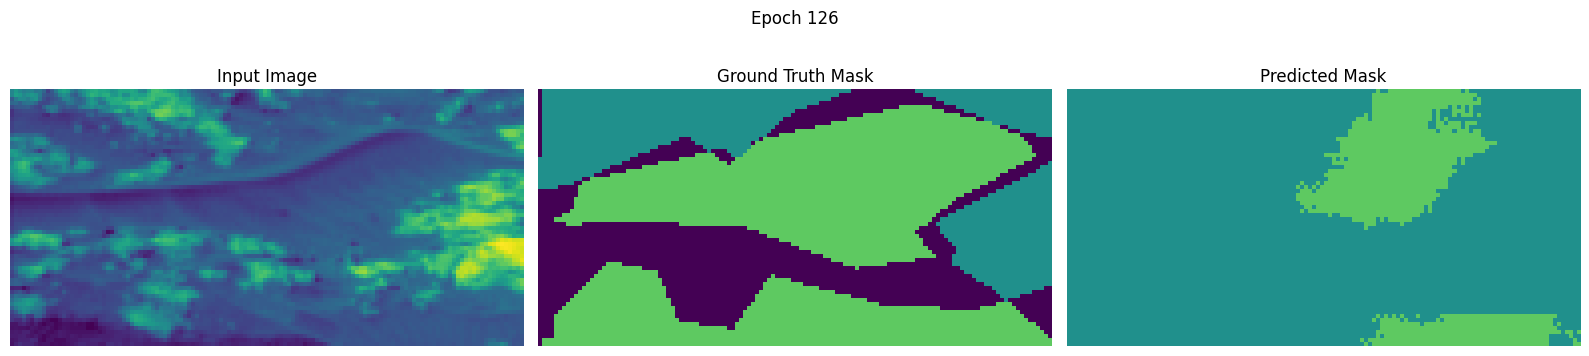

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6944 - loss: 0.1103 - mean_iou: 0.7043 - val_accuracy: 0.6951 - val_loss: 0.1151 - val_mean_iou: 0.6615 - learning_rate: 1.0000e-06
Epoch 127/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6974 - loss: 0.0993 - mean_iou: 0.7179 - val_accuracy: 0.6952 - val_loss: 0.1153 - val_mean_iou: 0.6616 - learning_rate: 1.0000e-06
Epoch 128/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6968 - loss: 0.0998 - mean_iou: 0.7207 - val_accuracy: 0.6950 - val_loss: 0.1154 - val_mean_iou: 0.6611 - learning_rate: 1.0000e-06
Epoch 129/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - accuracy: 0.6963 - loss: 0.1050 - mean_iou: 0.7117 - val_accuracy: 0.6950 - val_loss: 0.1154 - val_mean_iou: 0.6611 - learning_rate: 1.0000e-06
Epoch 130/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6947 - loss: 0.0970 - mean_iou: 0.7101 - val_accuracy: 0.6950 - val_loss: 0.1158 - val_mean_iou: 0.6609 - learning_rate: 1.0000e-06
Epoch 131/500


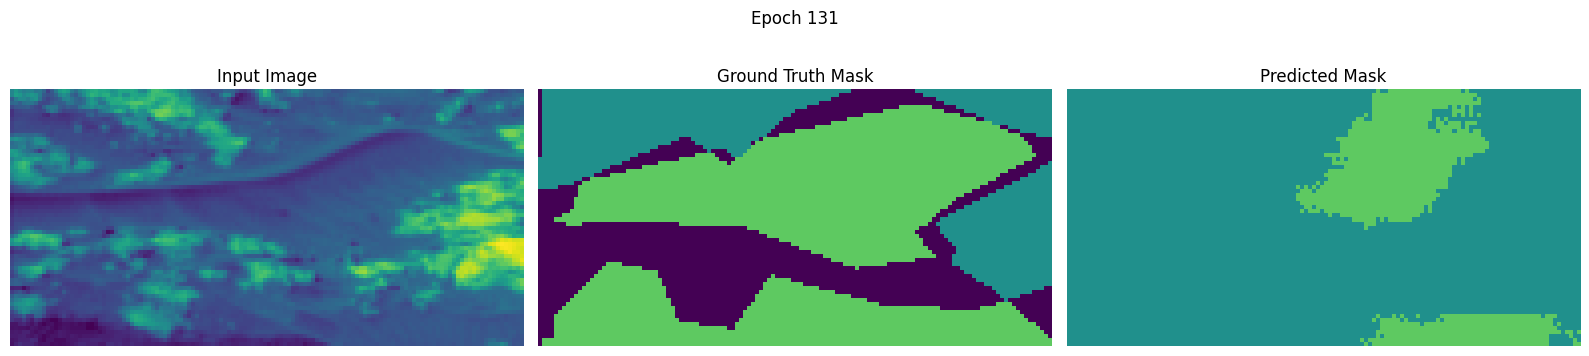

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7012 - loss: 0.0998 - mean_iou: 0.7084 - val_accuracy: 0.6946 - val_loss: 0.1157 - val_mean_iou: 0.6606 - learning_rate: 1.0000e-06
Epoch 132/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.7014 - loss: 0.0967 - mean_iou: 0.7234 - val_accuracy: 0.6948 - val_loss: 0.1160 - val_mean_iou: 0.6610 - learning_rate: 1.0000e-06
Epoch 133/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.6924 - loss: 0.1025 - mean_iou: 0.7206 - val_accuracy: 0.6946 - val_loss: 0.1158 - val_mean_iou: 0.6603 - learning_rate: 1.0000e-06
Epoch 134/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6901 - loss: 0.1072 - mean_iou: 0.7184 - val_accuracy: 0.6948 - val_loss: 0.1156 - val_mean_iou: 0.6610 - learning_rate: 1.0000e-06
Epoch 135/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6976 - loss: 0.1048 - mean_iou: 0.7187 - val_accuracy: 0.6949 - val_loss: 0.1159 - val_mean_iou: 0.6609 - learning_rate: 1.0000e-06
Epoch 136/500


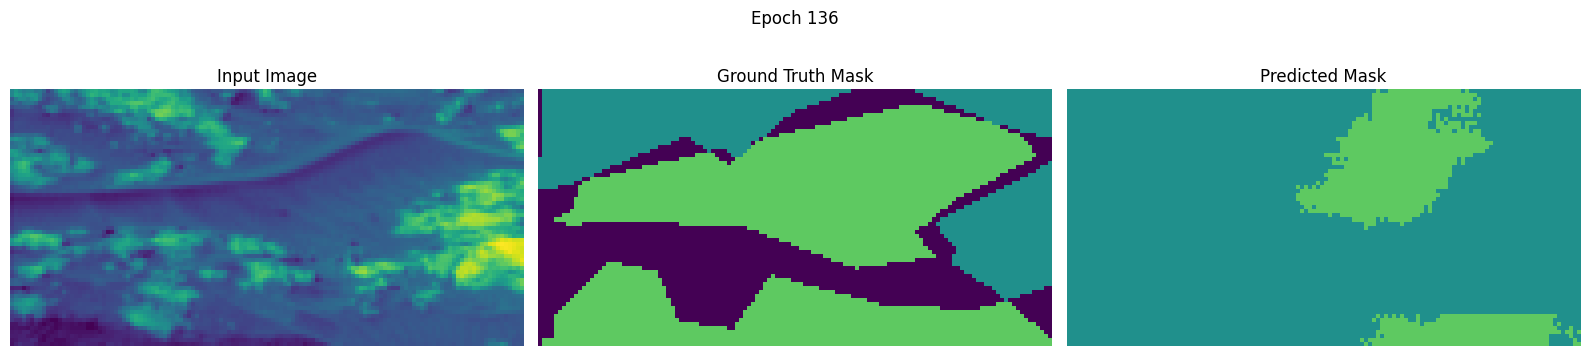

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.6947 - loss: 0.1041 - mean_iou: 0.7127 - val_accuracy: 0.6946 - val_loss: 0.1161 - val_mean_iou: 0.6599 - learning_rate: 1.0000e-06
Epoch 137/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6937 - loss: 0.0979 - mean_iou: 0.7307 - val_accuracy: 0.6942 - val_loss: 0.1163 - val_mean_iou: 0.6590 - learning_rate: 1.0000e-06
Epoch 138/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - accuracy: 0.6892 - loss: 0.1016 - mean_iou: 0.7202 - val_accuracy: 0.6941 - val_loss: 0.1160 - val_mean_iou: 0.6591 - learning_rate: 1.0000e-06
Epoch 139/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6913 - loss: 0.1035 - mean_iou: 0.6964 - val_accuracy: 0.6942 - val_loss: 0.1160 - val_mean_iou: 0.6591 - learning_rate: 1.0000e-06
Epoch 140/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6912 - loss: 0.0967 - mean_iou: 0.7062 - val_accuracy: 0.6941 - val_loss: 0.1159 - val_mean_iou: 0.6591 - learning_rate: 1.0000e-06
Epoch 141/500


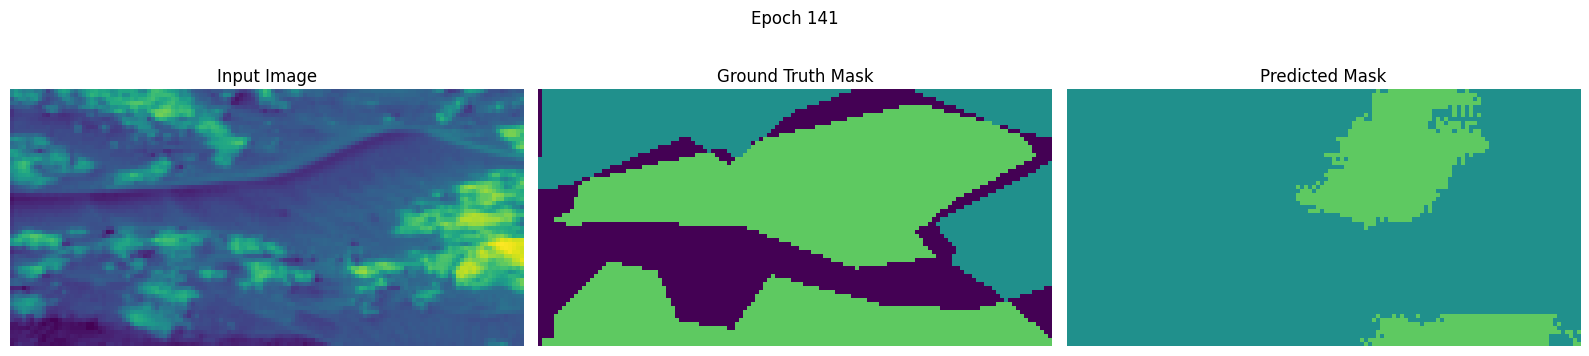

60/60 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6932 - loss: 0.1008 - mean_iou: 0.7127 - val_accuracy: 0.6946 - val_loss: 0.1157 - val_mean_iou: 0.6606 - learning_rate: 1.0000e-06
Epoch 142/500
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.6875 - loss: 0.1091 - mean_iou: 0.7108 - val_accuracy: 0.6947 - val_loss: 0.1158 - val_mean_iou: 0.6604 - learning_rate: 1.0000e-06


In [31]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, vizcallback, reduce_lr],
    verbose=1
).history

In [32]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 66.59%


Saved plot to img/035.pdf


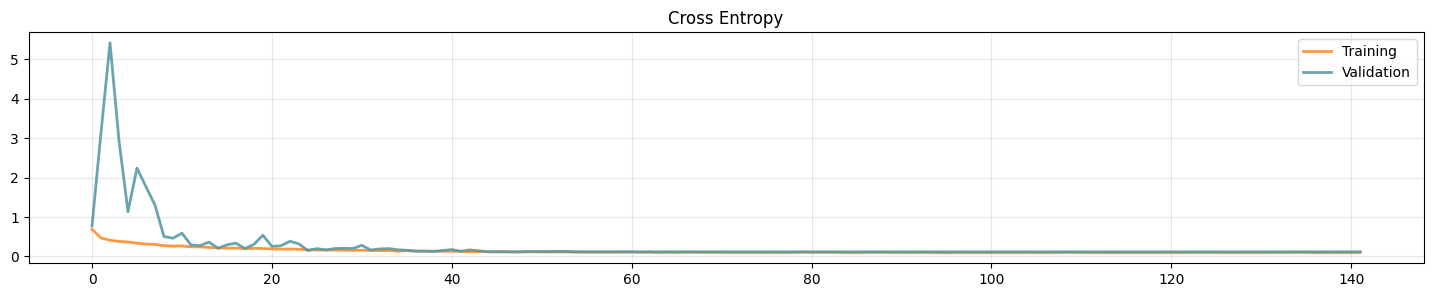

Saved plot to img/036.pdf


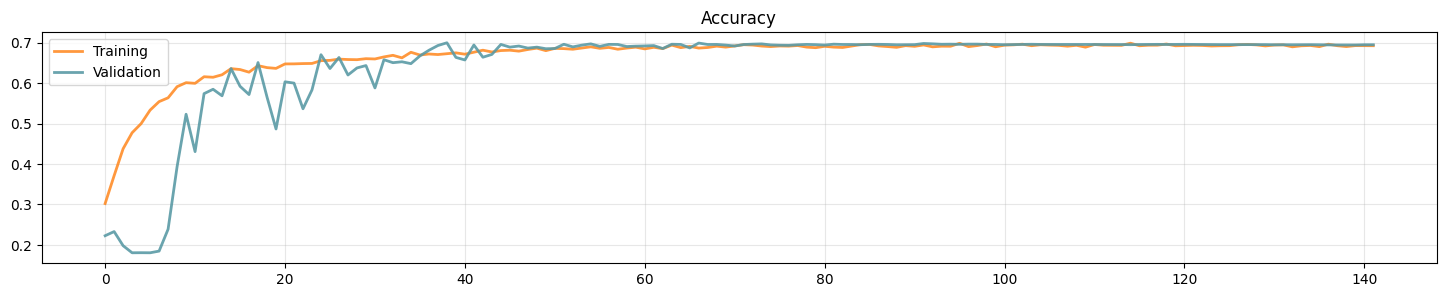

Saved plot to img/037.pdf


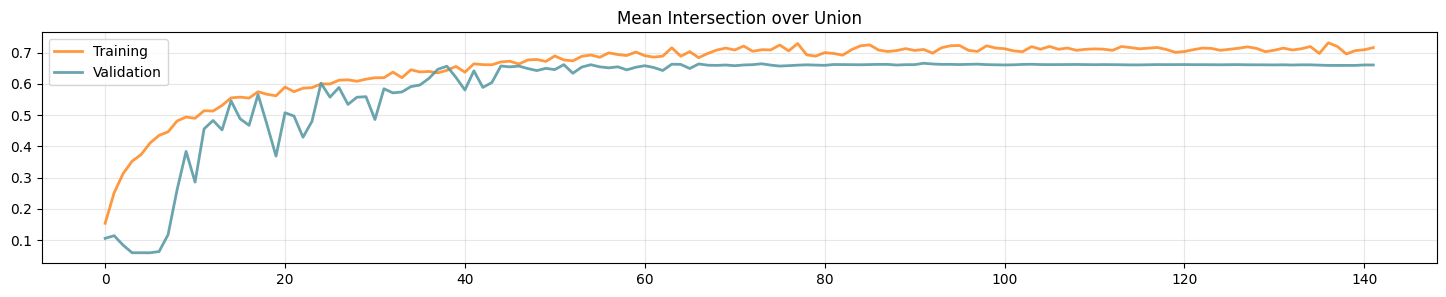

In [33]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [34]:
# Save model
timestep_str = datetime.now().strftime("%y%m%d_%H%M%S")
model_filename = f"model_{timestep_str}.keras"
model.save(model_filename)
del model

print(f"Model saved to {model_filename}")

Model saved to model_241211_092055.keras


## 📊 Prepare Your Submission

In our Kaggle competition, submissions are made as `csv` files. To create a proper `csv` file, you need to flatten your predictions and include an `id` column as the first column of your dataframe. To maintain consistency between your results and our solution, please avoid shuffling the test set. The code below demonstrates how to prepare the `csv` file from your model predictions.




In [35]:
# If model_filename is not defined, load the most recent model from Google Drive
if "model_filename" not in globals() or model_filename is None:
    files = [f for f in os.listdir('.') if os.path.isfile(f) and f.startswith('model_') and f.endswith('.keras')]
    files.sort(key=lambda x: os.path.getmtime(x), reverse=True)
    if files:
        model_filename = files[0]
    else:
        raise FileNotFoundError("No model files found in the current directory.")

In [36]:
# Load UNet model without compiling
model = tfk.models.load_model(model_filename, compile=False)

# Compile the model with specified loss, optimizer, and metrics
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tfk.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0])]
)
print(f"Model loaded from {model_filename}")

Model loaded from model_241211_092055.keras


In [37]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model.evaluate(test_dataset, verbose=0, batch_size=10)
print(f'Test Accuracy: {round(test_accuracy, 4)}')
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')

W0000 00:00:1733908866.147506      69 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1733908868.946449      68 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


Test Accuracy: 0.6818
Test Mean Intersection over Union: 0.6097


In [38]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step
Predictions shape: (10022, 64, 128)


In [39]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [40]:
# Create and download the csv submission file
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

if IN_COLAB:
    from google.colab import files
    files.download(submission_filename)